# ***Deep Learning - Assignment 4***

Student name - Leor Ariel Rose, ID - 208373365

Student name - Aviv Rovshitz, ID - 307974162

### ***Import packages***

Let's begin with importing all necessary packages:

In [56]:
# Data reading
import numpy as np
import pandas as pd
from scipy.io import arff

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Deep learning
import tensorflow as tf
from tensorflow.keras import (
    Model, Sequential, layers, initializers, optimizers, losses, metrics
)

# scikit-learn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# EDA
from pandas_profiling import ProfileReport

# Synthetic data evaluation
from table_evaluator import TableEvaluator

# Typing
from typing import Tuple, List, Dict, Any

# Randomness
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### ***Constant definitions***

Next, let's define some constant variables:

In [35]:
# Define the path containing the Data (german_credit.arff, diabetes.arff)
DATA_PATH = "./Data"

# Define the path containing the diabetes data
DIABETES_PATH = f"{DATA_PATH}/diabetes.arff"

# Define the path containing the german credit data
GERMAN_CREDIT_PATH = f"{DATA_PATH}/german_credit.arff"

# Define batch size
BATCH_SIZE = 32

# Define learning rate
LEARNING_RATE = 0.0002

# Define momentum rate
MOMENTUM_RATE = 0.5

# Define number of epochs
DIABETES_NUM_EPOCHS = 1500
G_CREDIT_NUM_EPOCHS = 200

# Define weight initialization object
WEIGHT_INIT = initializers.RandomNormal(mean=0.0, stddev=0.02)

### ***Auxiliary methods***

Next, let's define some auxiliary methods:

In [36]:
def read_arff(file_path: str) -> pd.DataFrame:
  """Method to read arff file as data frame.

  Args:
    file_path (str): Path to arff file.

  Returns:
    pd.DataFrame: Read data.

  """
  # Load arff data
  data, meta = arff.loadarff(file_path)
  # Create data frame from data and column names
  arff_df = pd.DataFrame(data, columns=meta.names())
  # Decode byte objects to strings
  for n, t in zip(meta.names(), meta.types()):
    if t == "nominal":
      arff_df[n] = arff_df[n].str.decode("utf-8")
  return arff_df


def get_num_and_cat_columns(df: pd.DataFrame) -> Tuple[List[str], ...]:
  """Method to get numeric and categorical column names from
    data frame.

  Args:
      df (pd.DataFrame): Data frame.

  Returns:
      Tuple[List[str, ...]]: Numeric and categorical column names.
  """
  # Get all categorical columns
  cat_cols = df.select_dtypes(include=['object', 'category']).columns
  # Get all numeric columns
  num_cols = df.select_dtypes(include=['number']).columns
  return num_cols, cat_cols


def pre_process_data(
    df: pd.DataFrame, num_cols: List[str], cat_cols: List[str]
) -> Tuple[pd.DataFrame, MinMaxScaler, OneHotEncoder]:
  """Method to preprocess a data frame.

  Args:
    df (pd.DataFrame): Data frame.
    num_cols (List[str]): Numeric column names.
    cat_cols (List[str]): Categorical column names.


  Returns:
    Tuple[pd.DataFrame, MinMaxScaler, OneHotEncoder]: Clean data frame,
      numeric transformer, categorical transformer.

  """
  # Define normalizers for datasets
  scalar = MinMaxScaler(feature_range=(-1, 1))

  # Define encoders for datasets
  encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

  # Copy to not change the original
  df = df.copy()

  # Convert all numeric columns to float32
  df[num_cols] = df[num_cols].astype(np.float32)

  # Normalize numeric columns
  df[num_cols] = (scalar.fit_transform(df[num_cols]))

  # One hot encoding of the categorical variable
  encoder.fit(df[cat_cols])
  df.loc[:,
         encoder.get_feature_names_out()] = encoder.fit_transform(df[cat_cols])
  df.drop(cat_cols, axis=1, inplace=True)

  # Convert all categorical columns to float32
  df[encoder.get_feature_names_out()
    ] = df[encoder.get_feature_names_out()].astype(np.float32)

  return df, scalar, encoder


def inverse_pre_process_data(
    clean_df: pd.DataFrame, num_cols: List[str], cat_cols: List[str],
    scalar: MinMaxScaler, encoder: OneHotEncoder
) -> pd.DataFrame:
  """Method to inverse preprocess of the a data frame.

  Args:
    clean_df (pd.DataFrame): Clean data frame.
    num_cols (List[str]): Numeric column names.
    cat_cols (List[str]): Categorical column names.
    scalar (MinMaxScaler): Numeric transformer.
    encoder (OneHotEncoder): Categorical transformer.

  Returns:
    pd.DataFrame: Data frame.

  """
  # Copy to not change the original
  clean_df = clean_df.copy()

  # de-normalize numeric columns
  clean_df[num_cols] = (scalar.inverse_transform(clean_df[num_cols]))

  # Convert all float64 to float32
  clean_df[num_cols] = clean_df[num_cols].astype(np.float64)

  # One hot encoding of the categorical variable
  clean_df[cat_cols] = encoder.inverse_transform(
      clean_df.loc[:, encoder.get_feature_names_out()]
  )
  clean_df.drop(encoder.get_feature_names_out(), axis=1, inplace=True)

  return clean_df

### ***Exploratory data analysis***

##### ***Diabetes exploratory data analysis***

Let's do some EDA on the diabetes datasets. We begin with reading the data:

In [4]:
# Read diabetes data
diabetes_df = read_arff(DIABETES_PATH)

Next, lets create an EDA report:

In [5]:
# Create EDA report
diabetes_profile = ProfileReport(diabetes_df, title="Diabetes EDA")
# Export EDA report to html file
diabetes_profile.to_file("diabetes_eda.html")
# Show EDA report
diabetes_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Next, let's preprocess the data:

In [6]:
# Get numeric and categorical column names 
diabetes_num_cols, diabetes_cat_cols = get_num_and_cat_columns(diabetes_df)
# Pre process
clean_diabetes_df, diabetes_scalar, diabetes_encoder = pre_process_data(
    diabetes_df, diabetes_num_cols, diabetes_cat_cols
)

Next, let's create features and class sets:

In [7]:
diabetes_X = clean_diabetes_df.loc[:, :"age"]
diabetes_y = clean_diabetes_df.loc[:, [
    "class_tested_negative", "class_tested_positive"
]]

##### ***German credit exploratory data analysis***

Let's do some EDA on the german credit datasets. We begin with reading the data:

In [8]:
# Read german credit data
g_credit_df = read_arff(GERMAN_CREDIT_PATH)

Next, lets create an EDA report:

In [9]:
# Create EDA report
g_credit_profile = ProfileReport(g_credit_df, title="German Credit EDA")
# Export EDA report to html file
g_credit_profile.to_file("german_credit_eda.html")
# Show EDA report
g_credit_profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Next, let's preprocess the data:

In [10]:
# Get numeric and categorical column names
g_credit_num_cols, g_credit_cat_cols = get_num_and_cat_columns(g_credit_df)
# Pre process
clean_g_credit_df, g_credit_scalar, g_credit_encoder = pre_process_data(
    g_credit_df, g_credit_num_cols, g_credit_cat_cols
)

Next, let's create features and class sets:

In [11]:
g_credit_X = clean_g_credit_df.loc[:, :"20_A202"]
g_credit_y = clean_g_credit_df.loc[:, ["21_1", "21_2"]]

### ***Part 1 – Generative Adversarial Networks***

In this part we will implement a simple GAN model for tabular data.
Let's start with implementing a GAN:

##### ***CGAN implementation***

In [38]:
def make_generator(latent_dim: int, layer_dim: int, data_dim: int) -> Model:
  """Method to create generator for gan.

  Args:
    latent_dim (int): The latent dimension to create noise.
    layer_dim (int): The layer dimension to create generator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Generator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=latent_dim),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(
              data_dim, activation="tanh", kernel_initializer=WEIGHT_INIT
          )
      ], name="generator"
  )


def make_discriminator(layer_dim: int, data_dim: int) -> Model:
  """Method to create discriminator for gan.

  Args:
    layer_dim (int): The layer dimension to create discriminator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Discriminator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=data_dim),
          layers.GaussianNoise(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(1, activation="sigmoid", kernel_initializer=WEIGHT_INIT)
      ], name="discriminator"
  )


class CGAN(Model):
  """Conditional GAN class.

  """

  def __init__(self, generator: Model, discriminator: Model, latent_dim: int):
    """Initializer method.

    Args:
      generator (Model): Generator model for CGAN.
      discriminator (Model): Discriminator model for CGAN.
      latent_dim (int): The latent dimension to create noise.

    """
    super(CGAN, self).__init__()

    # Save GAN parameters
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator

    # Create loss to track generator and discriminator for every batch
    self.g_loss_tracker = metrics.Mean(name="generator_loss")
    self.d_loss_tracker = metrics.Mean(name="discriminator_loss")

    # Create metrics to track discriminator for every batch
    self.real_bce_metric = metrics.BinaryAccuracy()
    self.fake_bce_metric = metrics.BinaryAccuracy()

  @property
  def metrics(self) -> Tuple[metrics.Mean, ...]:
    """Method to get metrics property.

    Returns:
        Tuple[metrics.Mean, ...]: GAN metrics.

    """
    return (
        self.g_loss_tracker, self.d_loss_tracker, self.real_bce_metric,
        self.fake_bce_metric
    )

  def compile(
      self, d_optimizer: optimizers.Optimizer,
      g_optimizer: optimizers.Optimizer, loss_fn: losses.Loss
  ):
    """Method to Configures the model for training.

    Args:
        d_optimizer (optimizers.Optimizer): Discriminator optimizer.
        g_optimizer (optimizers.Optimizer): Generator optimizer.
        loss_fn (losses.Loss): GAN loss function.

    """
    super(CGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  @tf.function
  def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
    """Method to apply Training process on every batch of data. 

    Args:
        data (Tuple[tf.Tensor, tf.Tensor]): Batch of data.

    Returns:
        Dict[str: float]: Metrics values of training step.

    """
    # Unpack records and labels
    real_records, one_hot_labels = data

    # Get data size
    data_size = tf.shape(real_records)[0]
    

    # Cast one hot labels to float32 for compatibility
    one_hot_labels = tf.cast(one_hot_labels, dtype=tf.float32)
    

    # Add random noise to the labels
    #noisy_one_hot_labels = one_hot_labels + (
    #    0.05 * tf.random.uniform(tf.shape(one_hot_labels))
    #)

    # Sample random points in the latent space for the generator
    # and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(data_size, self.latent_dim))
    random_vector_labels = tf.concat(
        [random_latent_vectors, one_hot_labels], axis=1
    )

    # Train the discriminator and generator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      # Decode the noise to fake records
      fake_records = self.generator(random_vector_labels)

      # concatenate the labels to fake and real records
      real_record_and_labels = tf.concat(
          [real_records, one_hot_labels], axis=1
      )
      fake_record_and_labels = tf.concat(
          [fake_records, one_hot_labels], axis=1
      )

      # Get discriminator prediction on ake and real records
      real_predictions = self.discriminator(real_record_and_labels)
      fake_predictions = self.discriminator(fake_record_and_labels)

      # Calculate real records loss
      d_real_loss = self.loss_fn(tf.ones((data_size, 1)), real_predictions)

      # Calculate fake records loss
      d_fake_loss = self.loss_fn(tf.zeros((data_size, 1)), fake_predictions)

      # Calculate discriminator and generator loss
      d_loss = (d_real_loss + d_fake_loss) / 2
      g_loss = self.loss_fn(tf.ones((data_size, 1)), fake_predictions)

    # Update generator and discriminator gradients
    g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
    d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(g_grads, self.generator.trainable_weights)
    )
    self.d_optimizer.apply_gradients(
        zip(d_grads, self.discriminator.trainable_weights)
    )

    # Update metrics
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)
    self.real_bce_metric.update_state(tf.ones((data_size, 1)), real_predictions)
    self.fake_bce_metric.update_state(
        tf.zeros((data_size, 1)), fake_predictions
    )
    return {
        "g_loss": self.g_loss_tracker.result(),
        "d_loss": self.d_loss_tracker.result(),
        "d_real_acc": self.real_bce_metric.result(),
        "d_fake_acc": self.fake_bce_metric.result()
    }

##### ***Diabetes training & evaluation***

Next, let's train a conditional GAN on the diabetes data:

In [40]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = diabetes_X.shape[-1]
num_class = diabetes_y.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=0.3)
)

# Train CGAN
history = cgan.fit(
    diabetes_X, diabetes_y, epochs=DIABETES_NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE
)

Epoch 1/1500
24/24 [==============================] - 2s 13ms/step - g_loss: 0.6934 - d_loss: 0.6929 - d_real_acc: 0.7942 - d_fake_acc: 0.9358
Epoch 2/1500
24/24 [==============================] - 0s 7ms/step - g_loss: 0.6929 - d_loss: 0.6937 - d_real_acc: 0.3532 - d_fake_acc: 0.3852
Epoch 3/1500
24/24 [==============================] - 0s 7ms/step - g_loss: 0.6964 - d_loss: 0.6926 - d_real_acc: 0.0554 - d_fake_acc: 0.9759
Epoch 4/1500
24/24 [==============================] - 0s 8ms/step - g_loss: 0.6915 - d_loss: 0.6926 - d_real_acc: 0.8474 - d_fake_acc: 0.2619
Epoch 5/1500
24/24 [==============================] - 0s 7ms/step - g_loss: 0.6943 - d_loss: 0.6927 - d_real_acc: 0.5354 - d_fake_acc: 0.5365
Epoch 6/1500
24/24 [==============================] - 0s 5ms/step - g_loss: 0.6969 - d_loss: 0.6915 - d_real_acc: 0.3621 - d_fake_acc: 0.6658
Epoch 7/1500
24/24 [==============================] - 0s 8ms/step - g_loss: 0.6830 - d_loss: 0.6933 - d_real_acc: 0.9789 - d_fake_acc: 0.0637
Epoch

Next, let's plot training metrics:

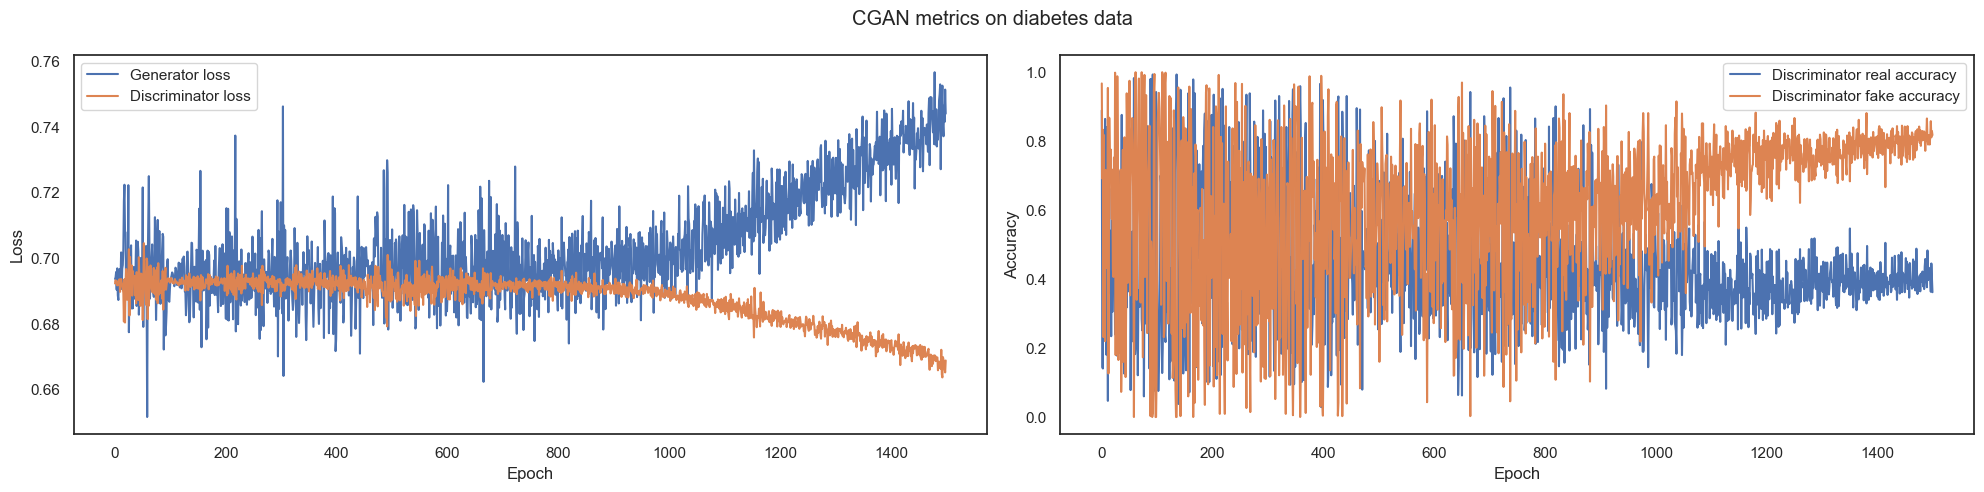

In [41]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [42]:
# Define number of samples to generate
num_samples = diabetes_X.shape[0]

# Get same labels as diabetes real labels
one_hot_labels = diabetes_y

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, one_hot_labels], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_diabetes_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_diabetes_df = pd.DataFrame(
    fake_records_and_labels, columns=clean_diabetes_df.columns
)

# Inverse preprocess
fake_diabetes_df = inverse_pre_process_data(
    fake_clean_diabetes_df, diabetes_num_cols, diabetes_cat_cols,
    diabetes_scalar, diabetes_encoder
)

# Sort fake data frame columns same as regular data frame columns 
fake_diabetes_df = fake_diabetes_df.reindex(diabetes_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

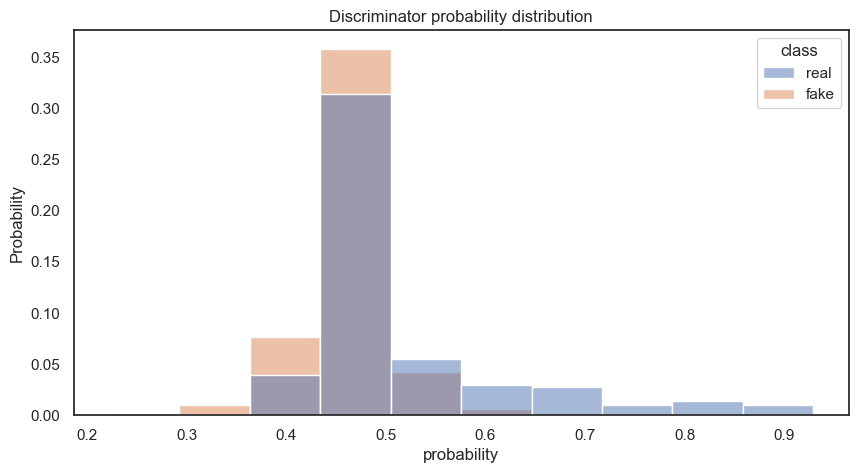

In [43]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [44]:
# Get records that fooled the discriminator
fooled = fake_diabetes_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 89


preg     plas    pres    skin     insu    mass   pedi     age  \
3   7.4737 147.4492 70.4209 26.1844 104.7815 26.6607 0.6242 65.4158   
6  11.5812 128.1913 76.9731 39.2189 235.6064 31.6616 0.7802 53.9625   
8   4.8471 148.5909 65.1356 30.2832 171.8436 28.8702 1.1992 24.7369   
9  14.9949 129.5001 82.6689 27.4262  57.4027 31.2568 0.2218 50.9599   
19  9.9887 152.0269 80.7614 24.9782  75.6045 26.6510 0.2458 50.3253   
23  0.0004 169.4560  0.0194  0.0000   0.0000 47.5794 0.3345 35.2289   
24  1.9767 153.3978  0.0285  0.0000   0.0000 33.7115 0.6046 25.0971   
31  0.0257 158.5532 87.9751 45.1267  88.8070 35.2092 1.5022 41.8356   
38  9.9156 177.4983 91.8948 31.6290  97.9621 35.3688 0.5738 43.9521   
51  6.6268 111.2876 66.8250 35.7260  49.1725 33.4442 0.7571 27.5204   

              class  
3   tested_negative  
6   tested_positive  
8   tested_positive  
9   tested_positive  
19  tested_positive  
23  tested_positive  
24  tested_positive  
31  tested_positive  
38  tested_positive  
51  tested_negative

In [45]:
# Get records that did not fool the discriminator
not_fooled = fake_diabetes_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    f"Number of sample that did not fool the discriminator: {not_fooled.shape[0]}"
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 679


preg     plas    pres    skin     insu    mass   pedi     age  \
0   3.4976 124.6493 64.1158 33.8297 128.2580 29.4544 0.7453 25.0001   
1   0.6202 112.9488 66.0868 41.6414  48.6825 35.3579 0.7905 23.2634   
2   6.2085 186.1474 71.7695  0.6676  74.0015 34.7594 0.4491 38.6505   
4  13.2792 111.4773 57.8712 32.4383 566.1941 33.1955 0.4099 50.2603   
5   0.1709 116.7475 77.7863 22.6273 117.0368 27.1701 0.6677 25.6319   
7   9.5663  74.7566 72.6938  0.0000   0.0000 30.4638 0.2923 37.3267   
10  1.3682 128.0701 56.7817 39.0112 111.8448 36.2355 0.7030 21.8987   
11  0.2250 144.4756 66.1199 44.1045  85.2575 30.1464 0.9783 23.5851   
12  8.3888 109.1755 65.0737 33.1315  51.0425 31.9117 0.3685 41.9892   
13  4.2018 170.2437 71.2136 32.0639  61.6694 25.9124 0.3900 25.9135   

              class  
0   tested_positive  
1   tested_negative  
2   tested_positive  
4   tested_positive  
5   tested_negative  
7   tested_negative  
10  tested_negative  
11  tested_positive  
12  tested_negative  
13  tested_positive

Lets evaluate the generated samples using table evaluator:

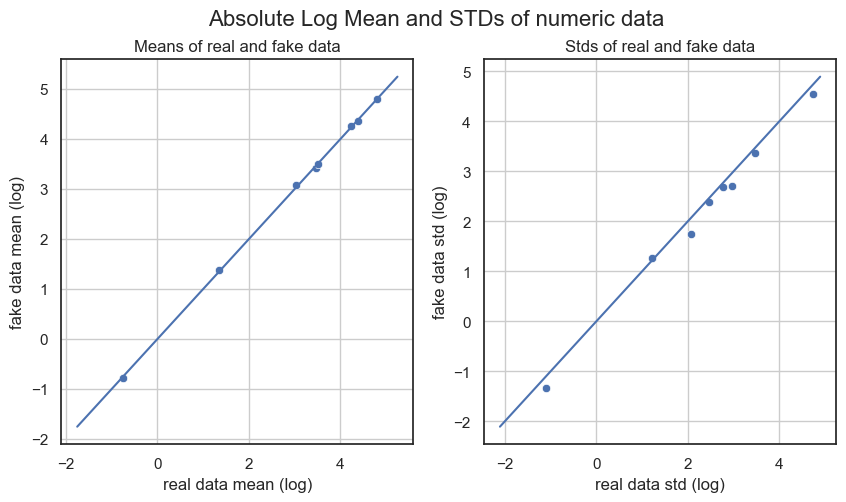

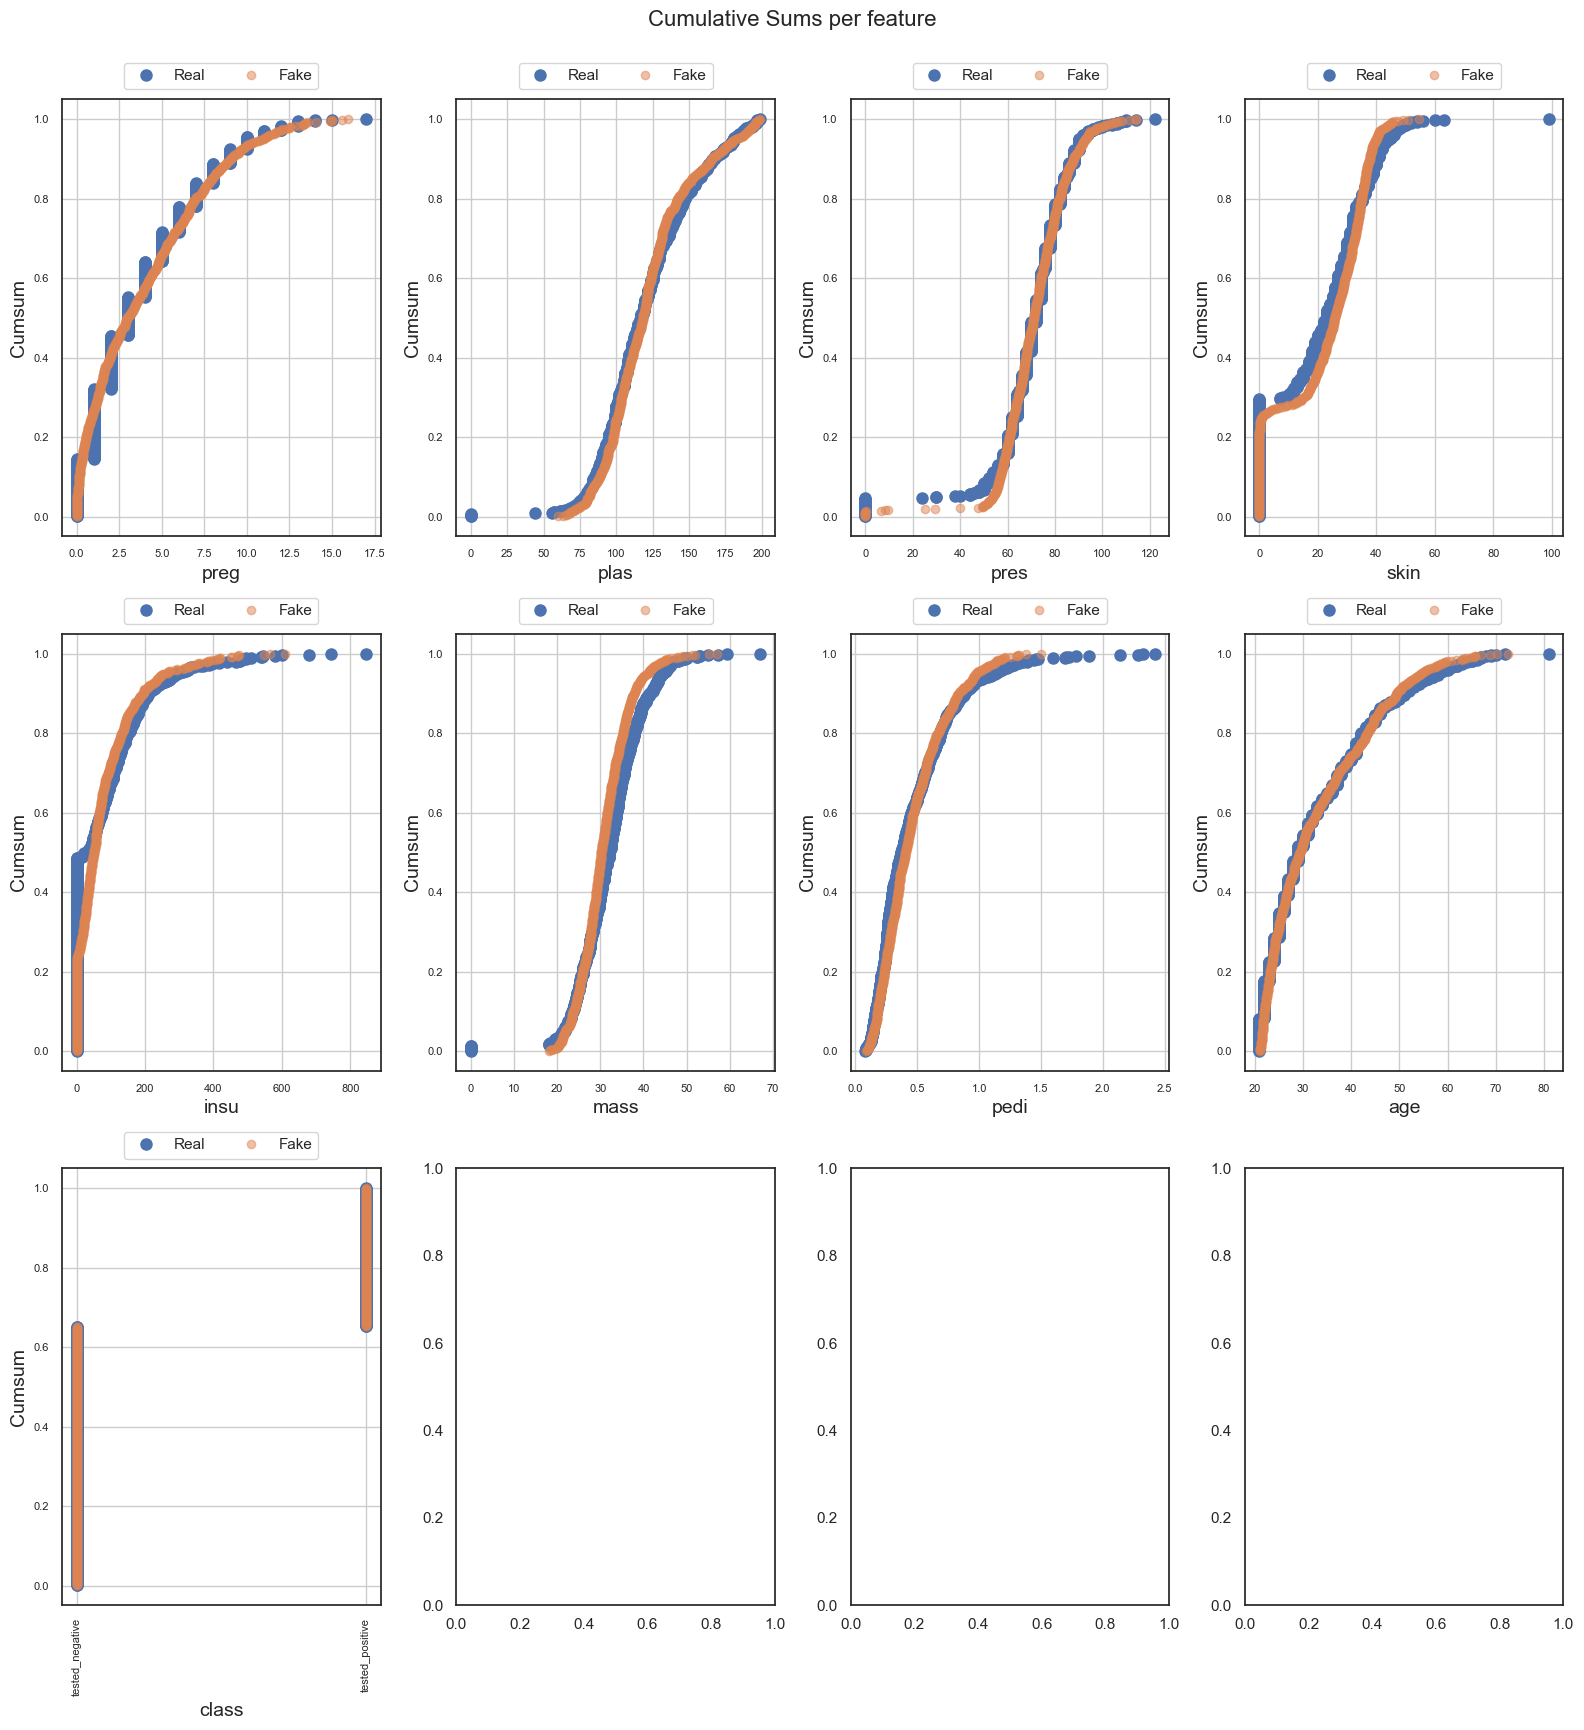

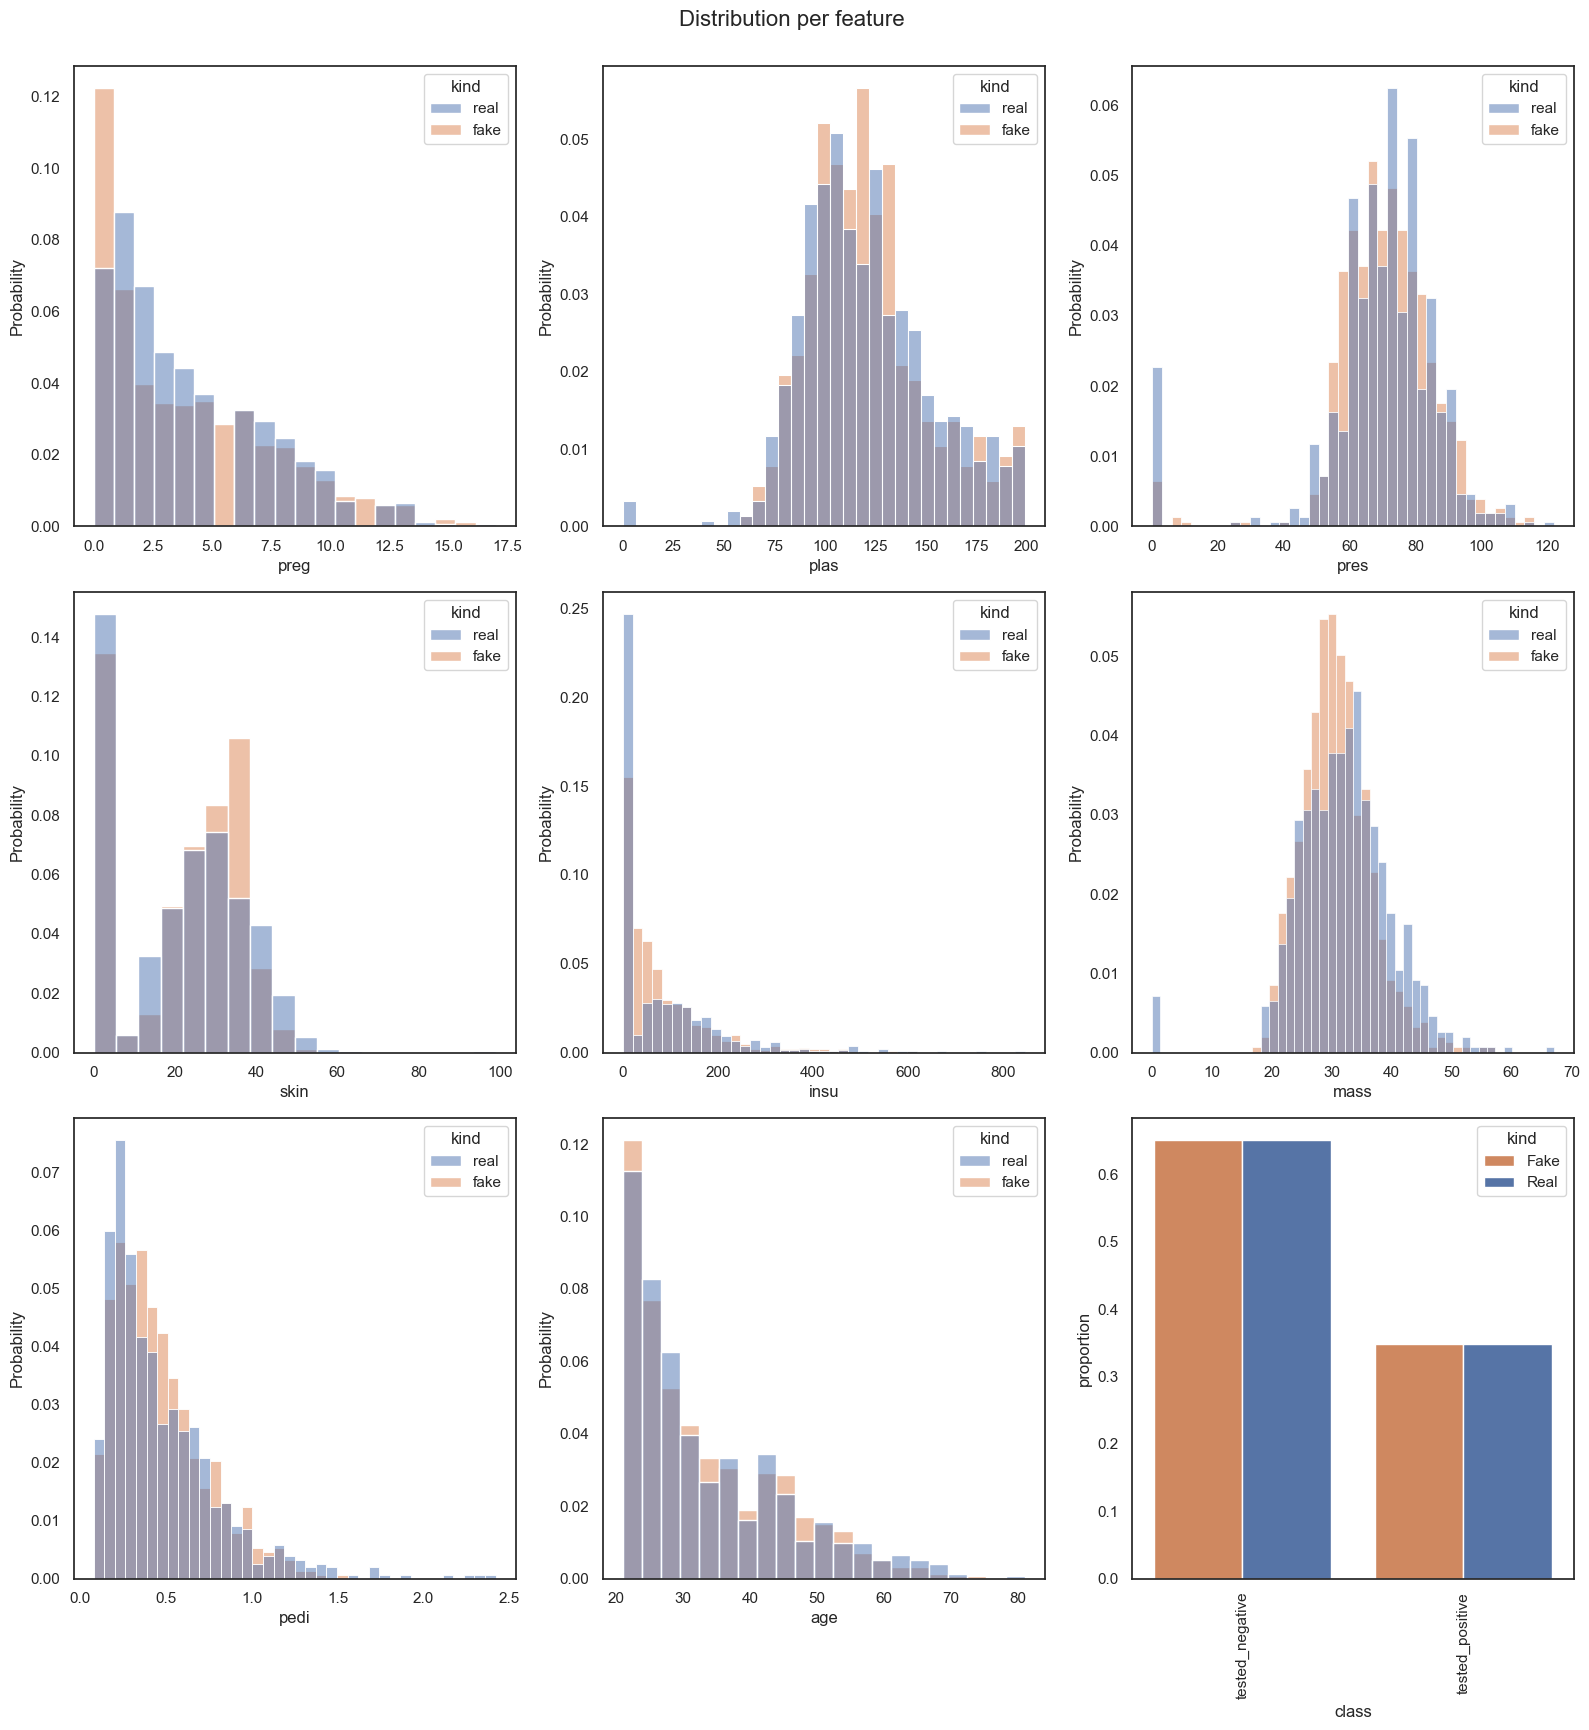

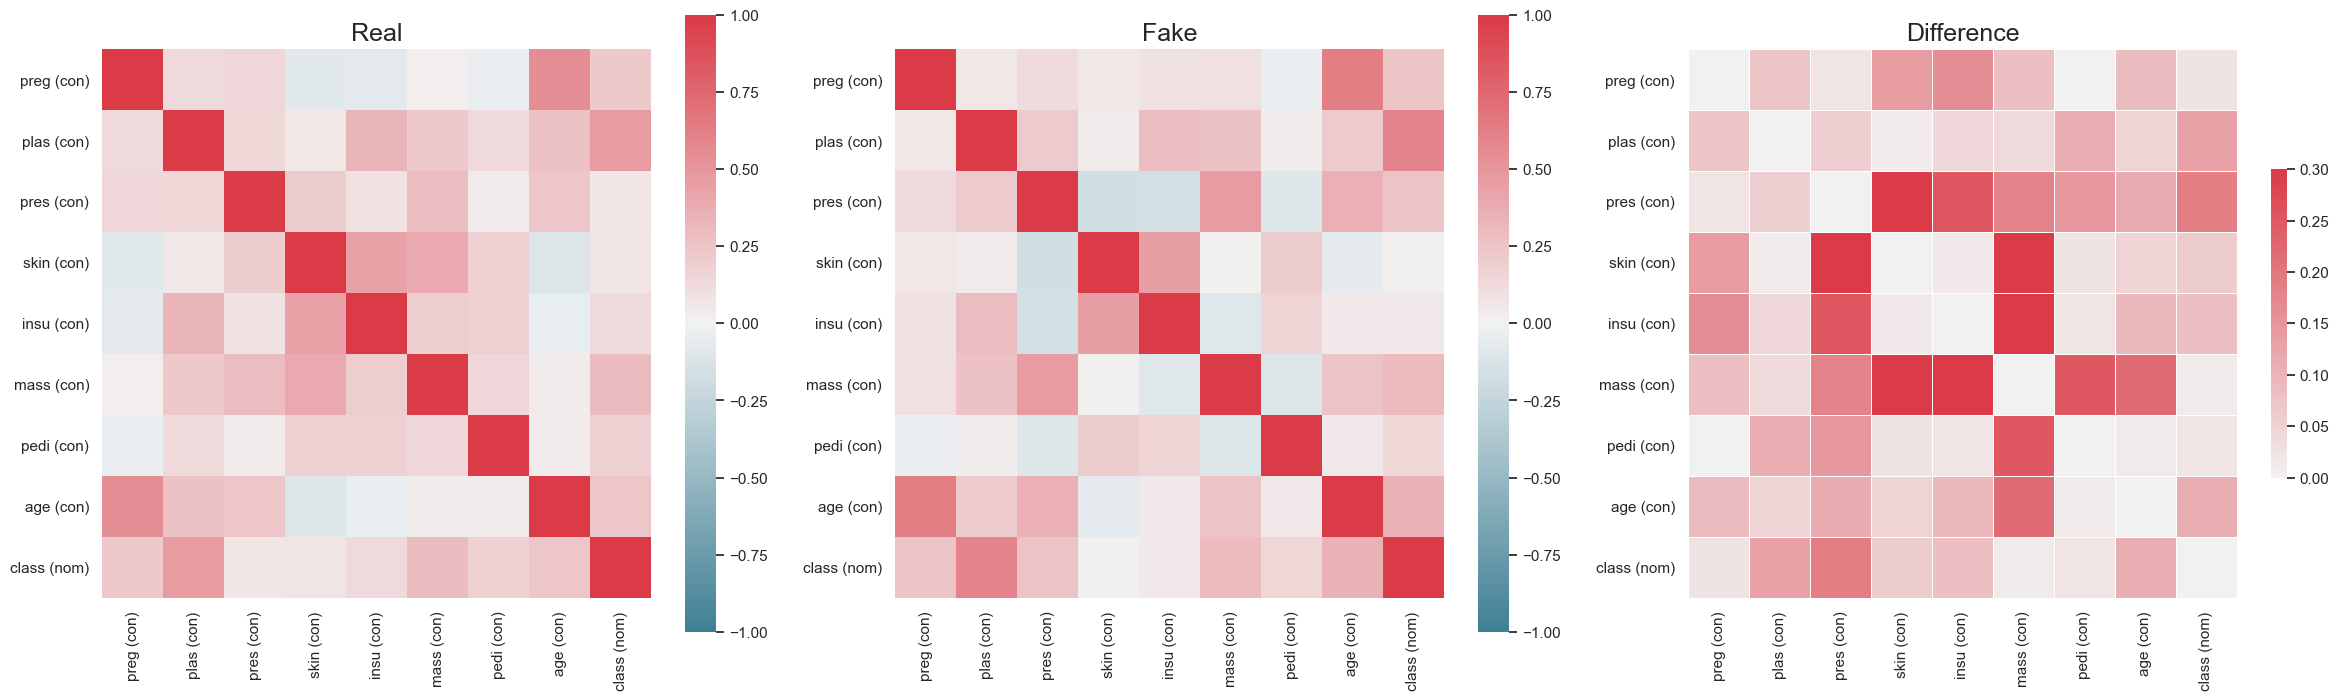

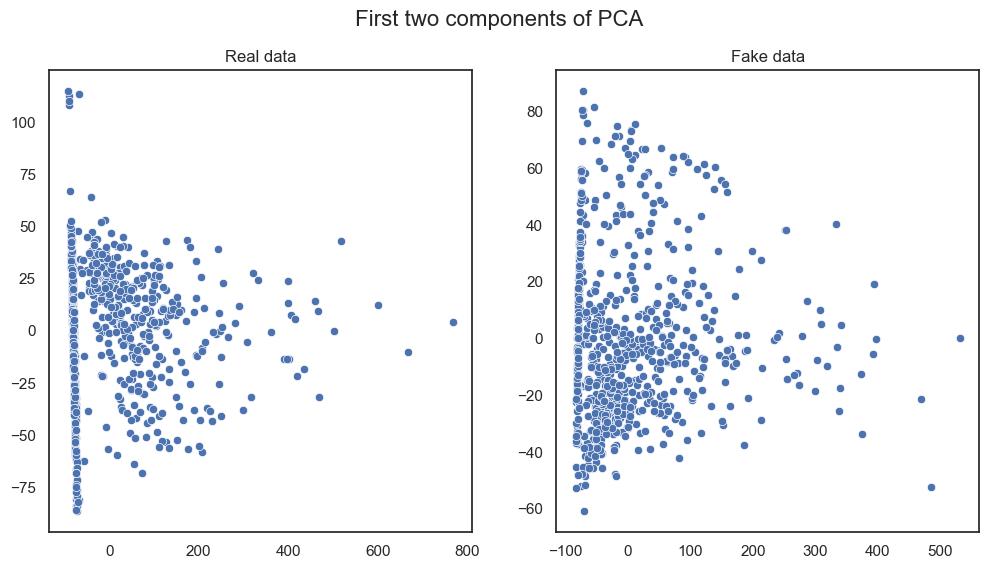


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7273   0.8506              0.5795
DecisionTreeClassifier_real   0.7468   0.7338              0.5876
LogisticRegression_fake       0.8247   0.8571              0.9130
LogisticRegression_real       0.7468   0.7468              0.8554
MLPClassifier_fake            0.6494   0.7727              0.4597
MLPClassifier_real            0.6883   0.6753              0.4951
RandomForestClassifier_fake   0.8571   0.8701              0.7303
RandomForestClassifier_real   0.7662   0.7532              0.6042

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.2024
nearest neighbor std                     0.5639

Miscellaneous results:
                                  Result
Column Cor

In [46]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    diabetes_df, fake_diabetes_df, cat_cols=diabetes_cat_cols.to_list()
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

##### ***German Credit training & evaluation***

Next, let's train a conditional GAN on the germen credit data:

In [47]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = g_credit_X.shape[-1]
num_class = g_credit_y.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=0.3)
)

# Train CGAN
history = cgan.fit(
    g_credit_X, g_credit_y, epochs=200, shuffle=True,
    batch_size=BATCH_SIZE
)

Epoch 1/200
32/32 [==============================] - 2s 12ms/step - g_loss: 0.6927 - d_loss: 0.6921 - d_real_acc: 0.9258 - d_fake_acc: 0.7877
Epoch 2/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.7012 - d_loss: 0.6919 - d_real_acc: 0.1567 - d_fake_acc: 1.0000
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.6901 - d_loss: 0.6889 - d_real_acc: 0.9440 - d_fake_acc: 0.4912
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - g_loss: 0.7082 - d_loss: 0.6901 - d_real_acc: 0.1405 - d_fake_acc: 0.8955
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.6906 - d_loss: 0.6927 - d_real_acc: 0.7324 - d_fake_acc: 0.3860
Epoch 6/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.6984 - d_loss: 0.6907 - d_real_acc: 0.4770 - d_fake_acc: 0.8210
Epoch 7/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.7170 - d_loss: 0.6876 - d_real_acc: 0.1733 - d_fake_acc: 0.8892
Epoch 8/200


Next, let's plot training metrics:

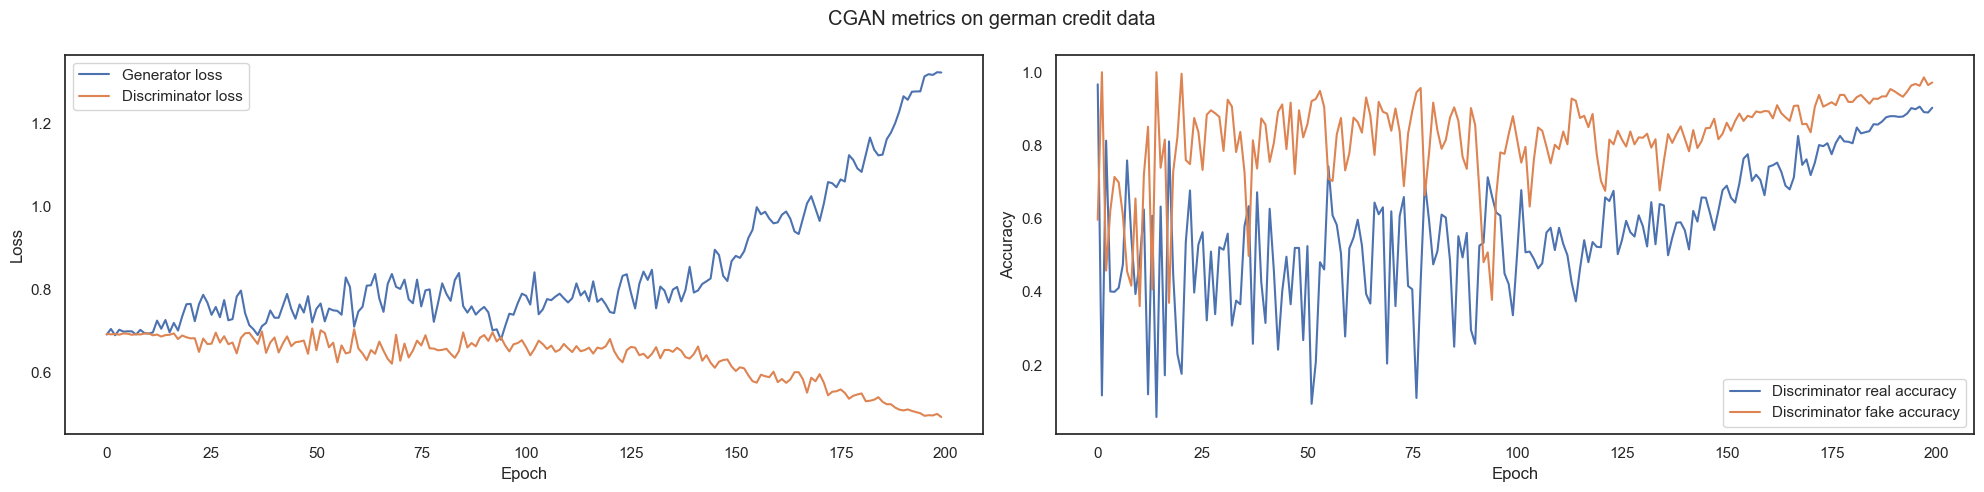

In [48]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on german credit data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [49]:
# Define number of samples to generate
num_samples = g_credit_X.shape[0]

# Get same labels as diabetes real labels
one_hot_labels = g_credit_y

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, one_hot_labels], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_g_credit_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_g_credit_df = pd.DataFrame(
    fake_records_and_labels, columns=clean_g_credit_df.columns
)

# Inverse preprocess
fake_g_credit_df = inverse_pre_process_data(
    fake_clean_g_credit_df, g_credit_num_cols, g_credit_cat_cols,
    g_credit_scalar, g_credit_encoder
)

# Sort fake data frame columns same as regular data frame columns 
fake_g_credit_df = fake_g_credit_df.reindex(g_credit_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

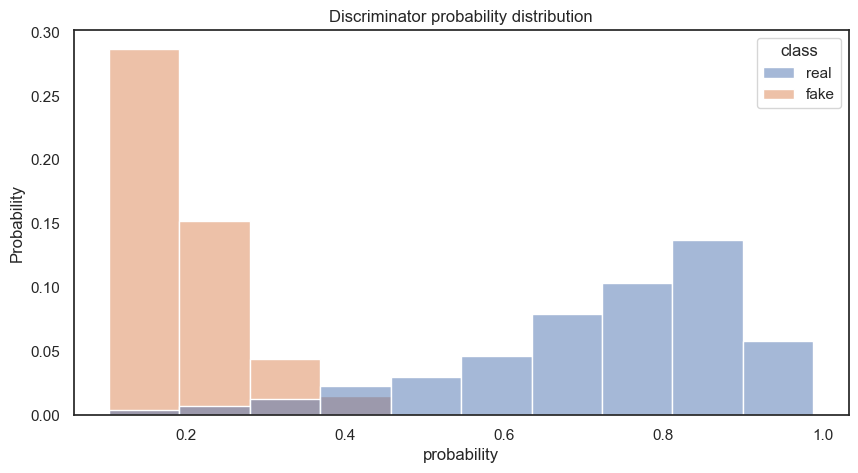

In [50]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [51]:
# Get records that fooled the discriminator
fooled = fake_g_credit_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 1


1       2    3    4          5    6    7      8    9    10  ...    12  \
474  A11 16.4626  A34  A43 1,089.1325  A61  A75 3.9999  A93  A102  ...  A124   

         13    14    15     16    17     18    19    20 21  
474 43.5715  A143  A151 2.0218  A172 1.0000  A191  A201  2  

[1 rows x 21 columns]

In [52]:
# Get records that did not fool the discriminator
not_fooled = fake_g_credit_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    f"Number of sample that did not fool the discriminator: {not_fooled.shape[0]}"
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 999


1       2    3    4          5    6    7      8    9    10  ...    12  \
0  A12 18.9309  A34  A43 1,370.4148  A61  A73 3.4900  A93  A101  ...  A123   
1  A11 23.3957  A34  A49 4,336.5348  A61  A73 3.7311  A93  A101  ...  A123   
2  A13 23.2366  A34  A49   897.6245  A61  A73 3.9774  A93  A101  ...  A123   
3  A12 29.6422  A33  A42 8,387.0774  A65  A73 1.0082  A92  A101  ...  A123   
4  A14 29.4792  A34  A42 7,206.9007  A61  A73 3.8862  A93  A101  ...  A122   
5  A11 16.8167  A32  A43 3,470.2462  A61  A73 3.8183  A93  A101  ...  A123   
6  A12 13.8834  A31  A49   877.6801  A61  A74 3.9645  A93  A101  ...  A123   
7  A14 40.1694  A34  A42 4,810.7716  A62  A72 3.9848  A92  A101  ...  A121   
8  A14 16.2548  A32  A41 5,103.8028  A65  A73 2.3354  A93  A101  ...  A123   
9  A12 35.7355  A34  A42 3,792.0200  A61  A73 1.8643  A93  A101  ...  A123   

       13    14    15     16    17     18    19    20 21  
0 28.9857  A141  A152 1.3895  A172 1.0008  A192  A201  1  
1 25.4621  A141  A152 1.9612  A173 1.0019  A192  A201  2  
2 38.8254  A141  A152 2.3867  A172 1.0003  A192  A201  1  
3 25.0783  A143  A152 1.2115  A174 1.0006  A192  A201  1  
4 37.9595  A143  A152 2.4092  A173 1.0001  A191  A201  2  
5 34.4055  A141  A152 2.2815  A173 1.0034  A192  A201  1  
6 20.4742  A141  A152 1.0903  A174 1.0001  A192  A201  1  
7 37.1083  A143  A152 1.4277  A172 1.0000  A191  A201  1  
8 27.1427  A141  A152 1.3340  A173 1.0003  A191  A201  1  
9 26.0091  A143  A152 1.6267  A172 1.0009  A191  A201  2  

[10 rows x 21 columns]

Lets evaluate the generated samples using table evaluator:

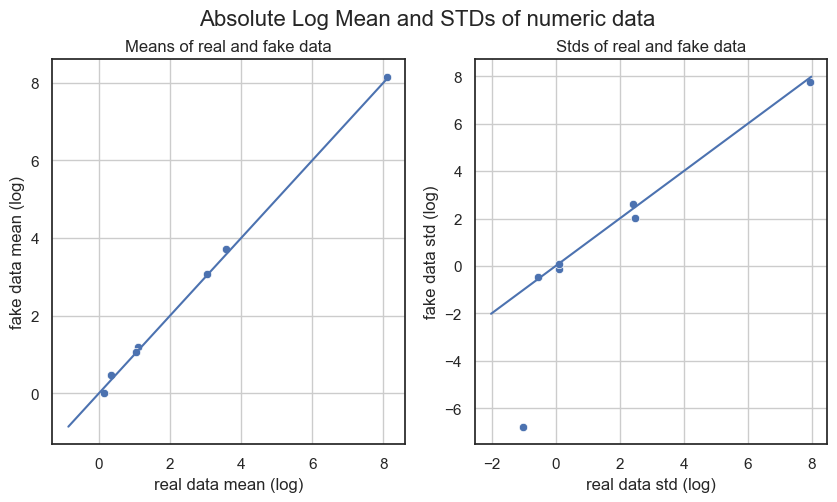

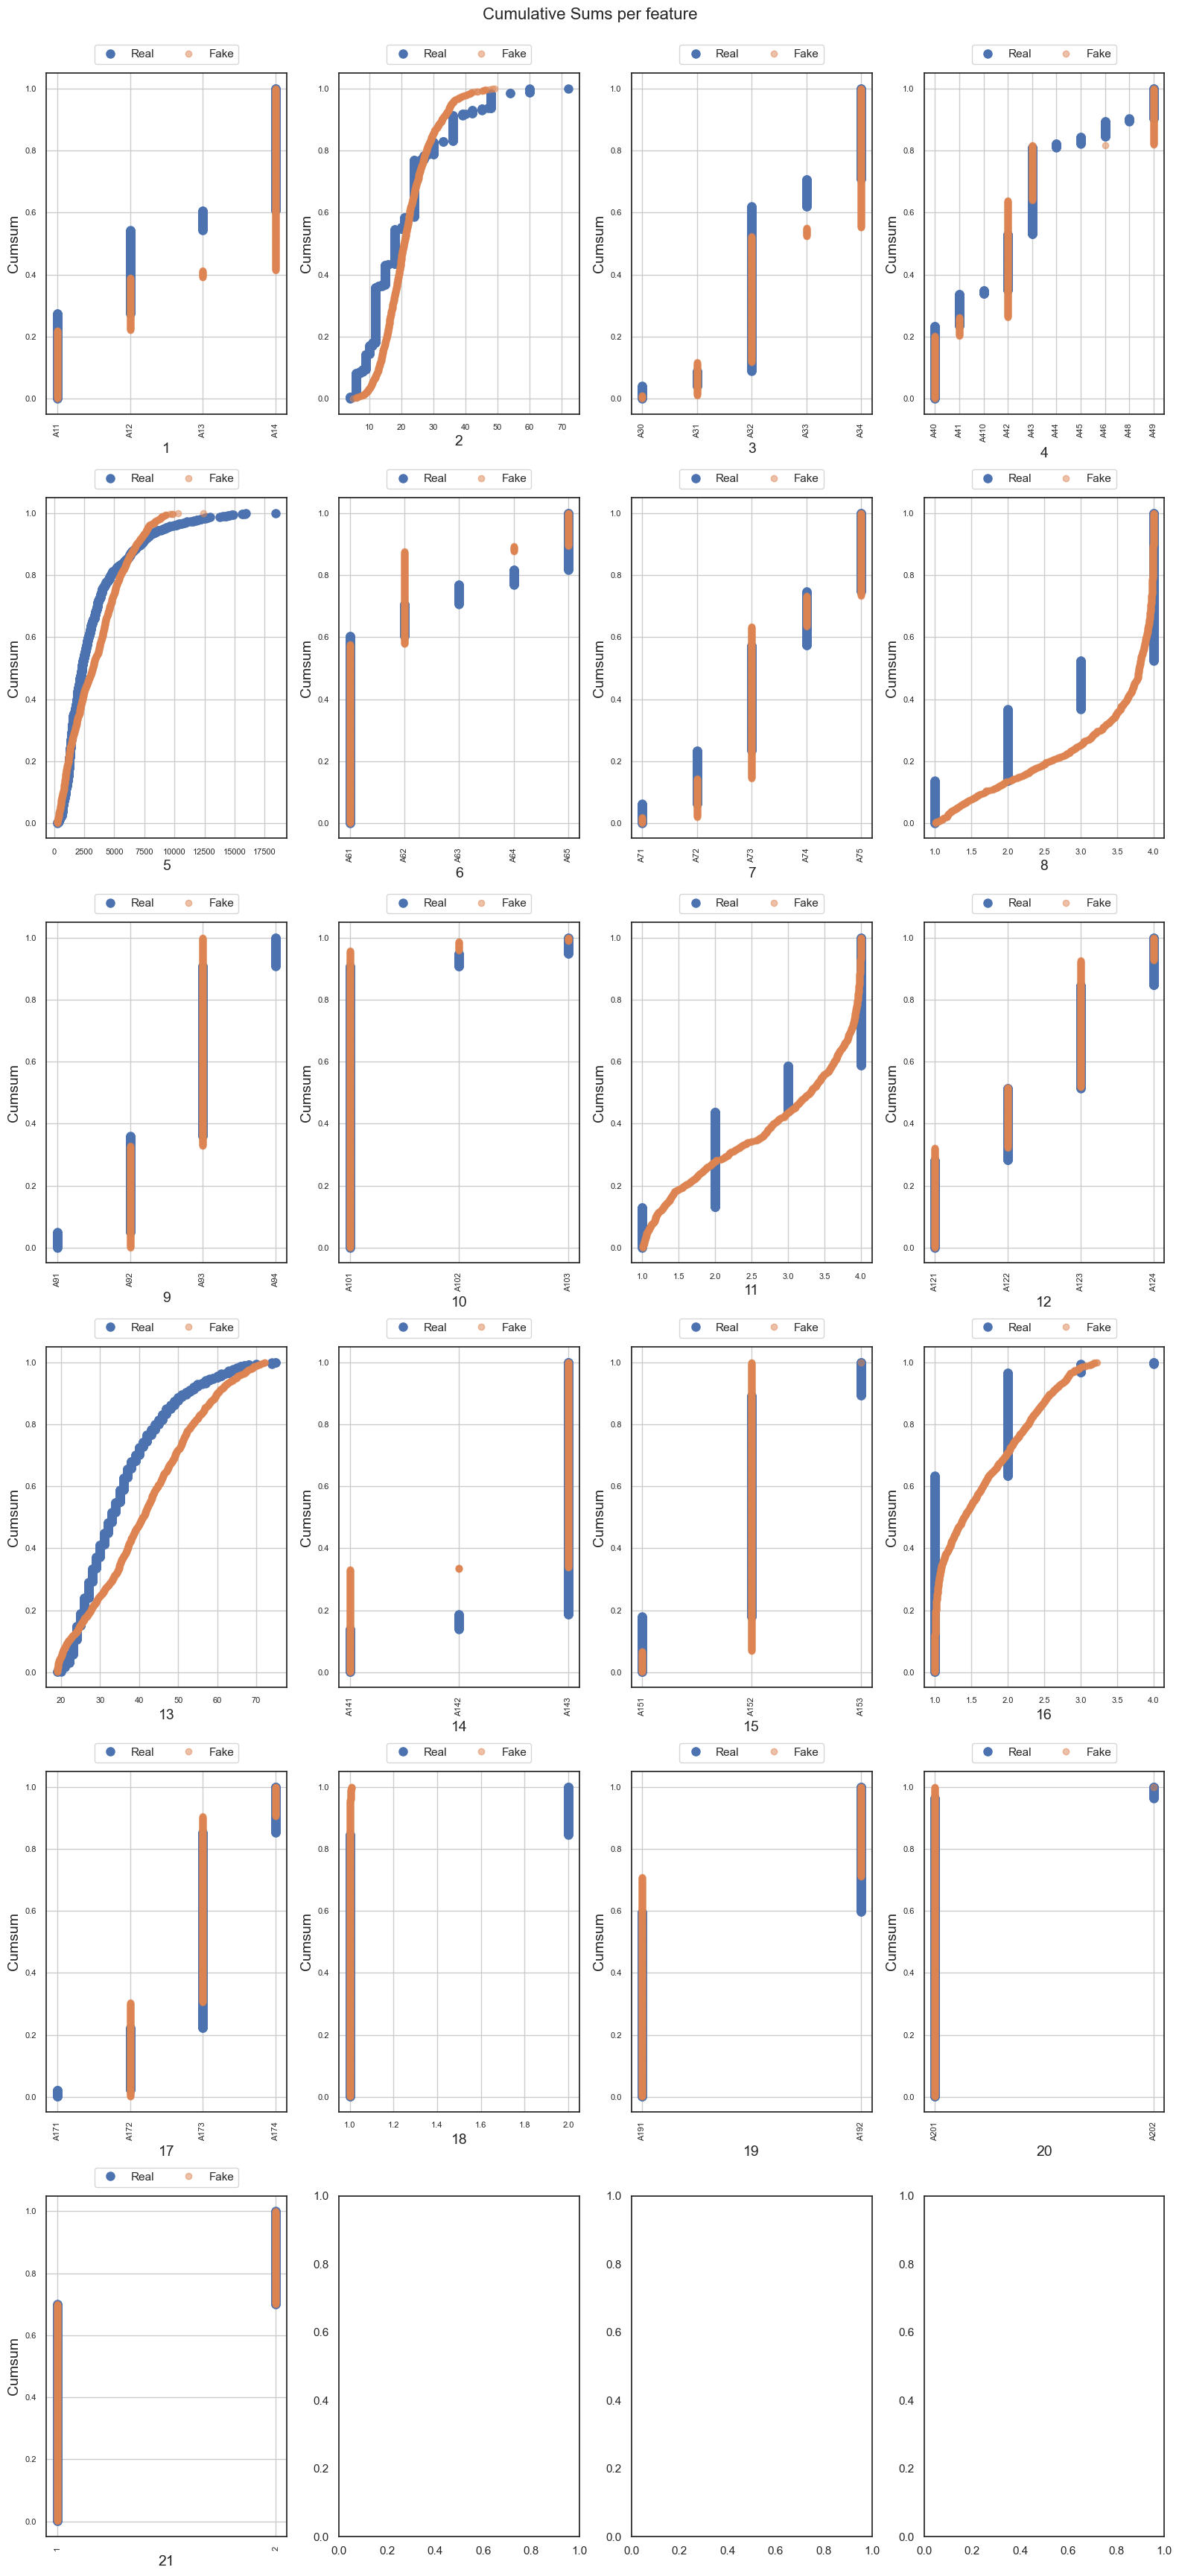

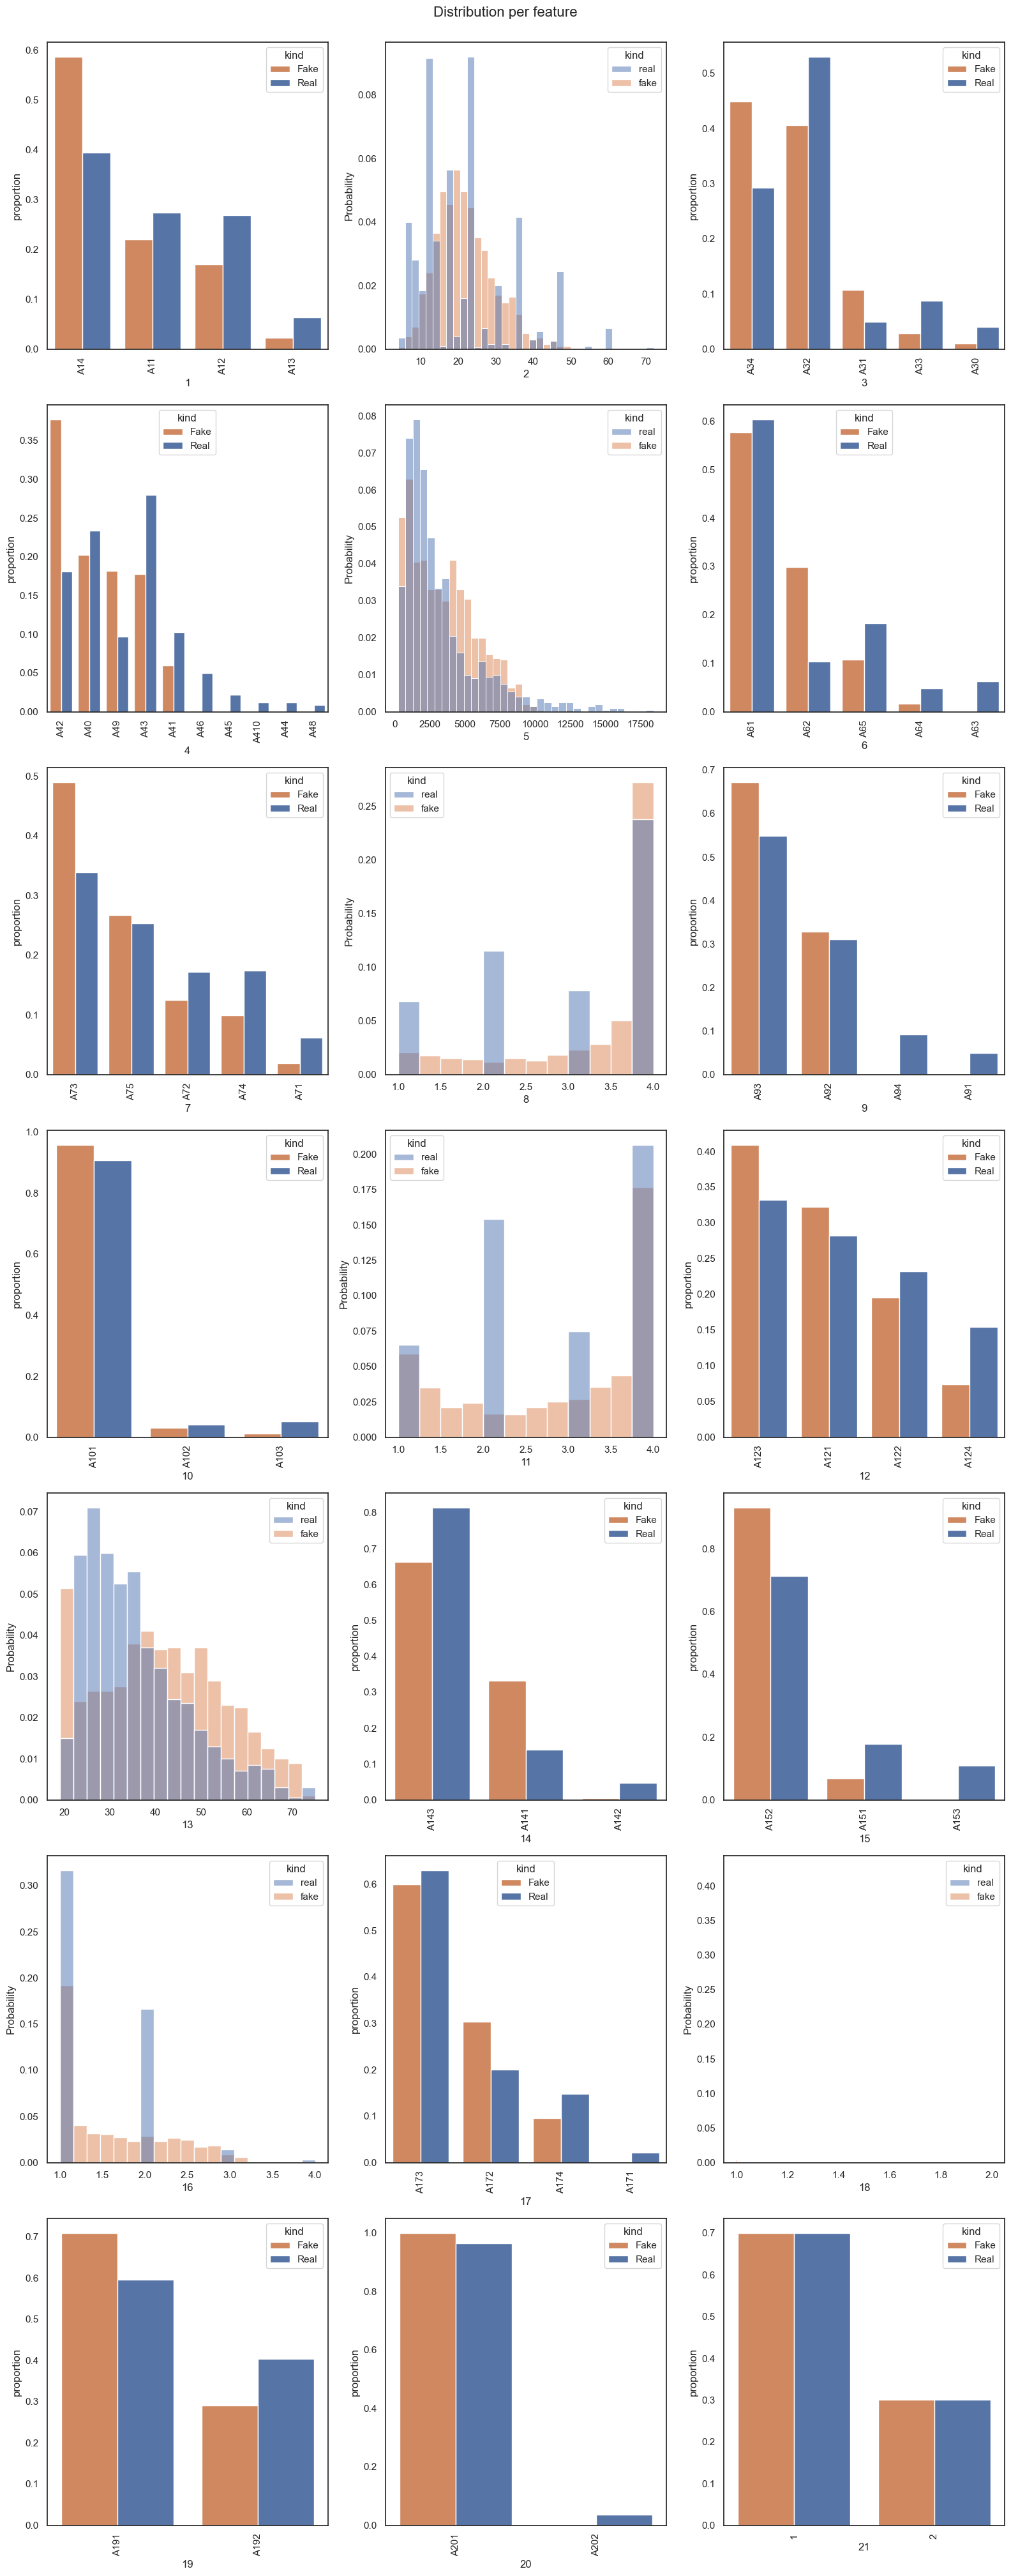

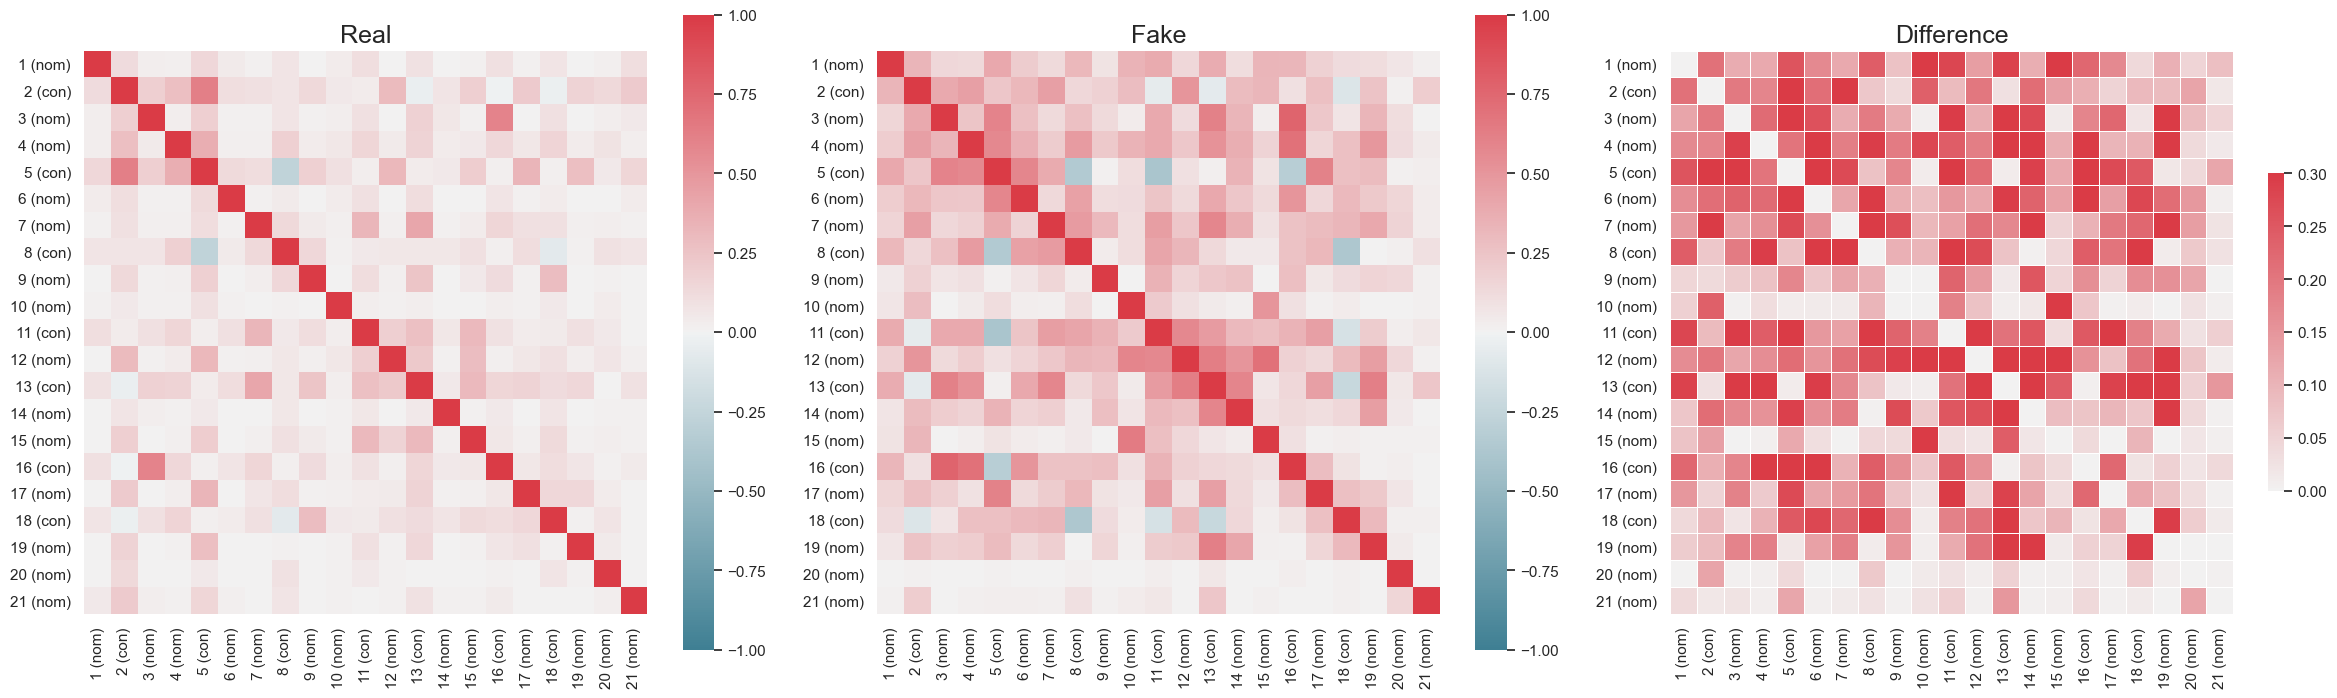

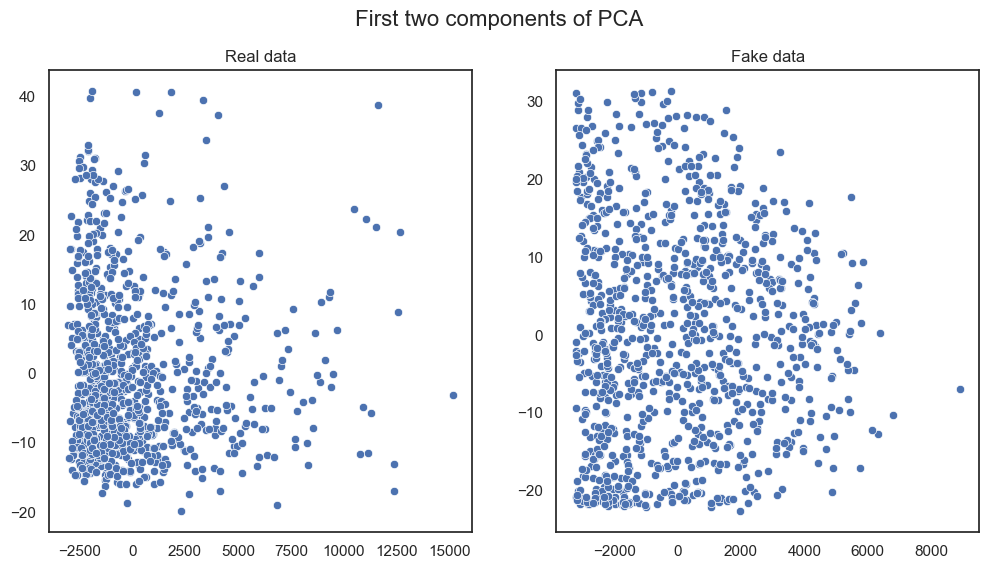


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.5650   0.7050              0.3889
DecisionTreeClassifier_real   0.6750   0.5550              0.3333
LogisticRegression_fake       0.6600   0.7450              0.6327
LogisticRegression_real       0.7750   0.7100              0.6327
MLPClassifier_fake            0.6950   0.6700              0.8779
MLPClassifier_real            0.7300   0.7200              0.8692
RandomForestClassifier_fake   0.6650   0.7500              0.6327
RandomForestClassifier_real   0.7300   0.6650              0.4981

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    3.3833
nearest neighbor std                     0.4345

Miscellaneous results:
                                  Result
Column Cor

In [53]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    g_credit_df, fake_g_credit_df, cat_cols=g_credit_cat_cols.to_list()
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="21")

### ***Part 2 – Generative Adversarial Networks with a twist***

In this part we will implement a simple GAN model for tabular data.
Let's start with implementing a GAN:

##### ***CGAN implementation***

In [141]:
def make_generator(latent_dim: int, layer_dim: int, data_dim: int) -> Model:
  """Method to create generator for gan.

  Args:
    latent_dim (int): The latent dimension to create noise.
    layer_dim (int): The layer dimension to create generator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Generator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=latent_dim),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dense(
              data_dim, activation="tanh", kernel_initializer=WEIGHT_INIT
          )
      ], name="generator"
  )


def make_discriminator(layer_dim: int, data_dim: int) -> Model:
  """Method to create discriminator for gan.

  Args:
    layer_dim (int): The layer dimension to create discriminator model.
    data_dim (int): The data dimension to create records.

  Returns:
    Model: Discriminator for gan.

  """
  return Sequential(
      [
          layers.InputLayer(input_shape=data_dim),
          layers.GaussianNoise(0.2),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(layer_dim, kernel_initializer=WEIGHT_INIT),
          layers.BatchNormalization(),
          layers.LeakyReLU(0.2),
          layers.Dropout(0.5),
          layers.Dense(1, activation="sigmoid", kernel_initializer=WEIGHT_INIT)
      ], name="discriminator"
  )


class CGAN(Model):
  """Conditional GAN class.

  """

  def __init__(
      self, generator: Model, discriminator: Model, black_box: Any,
      latent_dim: int
  ):
    """Initializer method.

    Args:
      generator (Model): Generator model for CGAN.
      discriminator (Model): Discriminator model for CGAN.
      latent_dim (int): The latent dimension to create noise.

    """
    super(CGAN, self).__init__()

    # Save GAN parameters
    self.latent_dim = latent_dim
    self.generator = generator
    self.discriminator = discriminator
    self.black_box = black_box

    # Create loss to track generator and discriminator for every batch
    self.g_loss_tracker = metrics.Mean(name="generator_loss")
    self.d_loss_tracker = metrics.Mean(name="discriminator_loss")

    # Create metrics to track discriminator for every batch
    self.c_bce_metric = metrics.BinaryAccuracy()
    self.y_bce_metric = metrics.BinaryAccuracy()

  @property
  def metrics(self) -> Tuple[metrics.Mean, ...]:
    """Method to get metrics property.

    Returns:
        Tuple[metrics.Mean, ...]: GAN metrics.

    """
    return (
        self.g_loss_tracker, self.d_loss_tracker, self.c_bce_metric,
        self.y_bce_metric
    )

  def compile(
      self, d_optimizer: optimizers.Optimizer,
      g_optimizer: optimizers.Optimizer, loss_fn: losses.Loss
  ):
    """Method to Configures the model for training.

    Args:
        d_optimizer (optimizers.Optimizer): Discriminator optimizer.
        g_optimizer (optimizers.Optimizer): Generator optimizer.
        loss_fn (losses.Loss): GAN loss function.

    """
    super(CGAN, self).compile(run_eagerly=True)
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, garbage_data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
    """Method to apply Training process on every batch of data. 

    Args:
        data (Tuple[tf.Tensor, tf.Tensor]): Batch of data.

    Returns:
        Dict[str: float]: Metrics values of training step.

    """
    # Unpack data
    _, _ = garbage_data

    # Get data size
    data_size = tf.shape(_)[0]

    # Sample random points in the latent space for the generator
    # and concatenate a random confidence score.
    random_latent_vectors = tf.random.normal(shape=(data_size, self.latent_dim))
    c = tf.random.uniform(shape=(data_size, 1), minval=0, maxval=1)
    random_vector_labels = tf.concat(
        [random_latent_vectors, c], axis=1
    )

    # Train the discriminator and generator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
      # Decode the noise to fake records
      fake_records = self.generator(random_vector_labels, training=True)
      
      # Get classification confidence score
      y = clf.predict_proba([fake_records[0].numpy()])
      

      # concatenate the classification confidence score and random confidence
      # score to fake records
      fake_records_c = tf.concat([fake_records, c], axis=1)
      fake_records_y = tf.concat([fake_records, y], axis=1)

      # Get discriminator prediction
      fake_records_c_predictions = self.discriminator(fake_records_c)
      fake_records_y_predictions = self.discriminator(fake_records_y)

      # Calculate c loss
      d_c_loss = self.loss_fn(tf.zeros((data_size, 1)), fake_records_c_predictions)

      # Calculate y loss
      d_y_loss = self.loss_fn(tf.ones((data_size, 1)), fake_records_y_predictions)

      # Calculate discriminator and generator loss
      d_loss = (d_c_loss + d_y_loss) / 2
      g_loss = self.loss_fn(tf.ones((data_size, 1)), fake_records_c_predictions)

    # Update generator and discriminator gradients
    g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
    d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(g_grads, self.generator.trainable_weights)
    )
    self.d_optimizer.apply_gradients(
        zip(d_grads, self.discriminator.trainable_weights)
    )

    # Update metrics
    self.g_loss_tracker.update_state(g_loss)
    self.d_loss_tracker.update_state(d_loss)
    self.c_bce_metric.update_state(tf.zeros((data_size, 1)), fake_records_c_predictions)
    self.y_bce_metric.update_state(
        tf.ones((data_size, 1)), fake_records_y_predictions
    )
    return {
        "g_loss": self.g_loss_tracker.result(),
        "d_loss": self.d_loss_tracker.result(),
        "d_c_acc": self.c_bce_metric.result(),
        "d_y_acc": self.y_bce_metric.result()
    }

##### ***Diabetes training & evaluation***

Next, let's train a RandomForest on the diabetes data:

In [134]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
#
diabetes_x_train, diabetes_x_test, diabetes_y_train, diabetes_y_test = (
    train_test_split(diabetes_X, diabetes_y, test_size=0.3, random_state=SEED)
)
#
clf = RandomForestClassifier(max_depth=2, random_state=0)
#
clf.fit(diabetes_x_train.to_numpy(), lb.fit_transform(diabetes_encoder.inverse_transform(diabetes_y_train)))
#
clf.predict_proba(diabetes_x_test)[:, 1]

C:\Users\Leor\AppData\Local\Temp\ipykernel_20700\3038202409.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(diabetes_x_train.to_numpy(), lb.fit_transform(diabetes_encoder.inverse_transform(diabetes_y_train)))
c:\Users\Leor\anaconda3\envs\ass_5\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0.42409745, 0.24400575, 0.20875448, 0.3391294 , 0.48788621,
       0.4383508 , 0.12418613, 0.38090672, 0.50945731, 0.48110959,
       0.33876842, 0.61451105, 0.43927753, 0.3756614 , 0.14776545,
       0.35196273, 0.25713948, 0.22680866, 0.47444249, 0.33586487,
       0.29785812, 0.30493486, 0.42298386, 0.20300278, 0.51658732,
       0.64400049, 0.18629392, 0.15737529, 0.26422949, 0.35725461,
       0.50356075, 0.48756727, 0.61636735, 0.53487759, 0.38819882,
       0.6192549 , 0.5951867 , 0.38181222, 0.33105116, 0.33792543,
       0.17433822, 0.32794362, 0.39190156, 0.43287941, 0.20751818,
       0.53543214, 0.4350254 , 0.28974261, 0.33504158, 0.64516587,
       0.13759749, 0.63258692, 0.59835202, 0.25915305, 0.22122144,
       0.18725674, 0.54822514, 0.14107166, 0.27214492, 0.5547443 ,
       0.56173031, 0.26870527, 0.41412102, 0.36607679, 0.24784754,
       0.42155063, 0.15268902, 0.48330958, 0.17471892, 0.57857037,
       0.60534869, 0.32121556, 0.28393349, 0.22862968, 0.22736

Next, let's train a conditional GAN on the diabetes data:

In [142]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = diabetes_X.shape[-1]
c_dim = 1

# Create CGAN
gen = make_generator(latent_dim + c_dim, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + c_dim)
cgan = CGAN(gen, dis, clf ,latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=0.3)
)

# Train CGAN
history = cgan.fit(
    diabetes_X, diabetes_y, epochs=DIABETES_NUM_EPOCHS, shuffle=True, batch_size=BATCH_SIZE
)

Epoch 1/1500


InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [32,8] vs. shape[1] = [1,2] [Op:ConcatV2] name: concat

Next, let's plot training metrics:

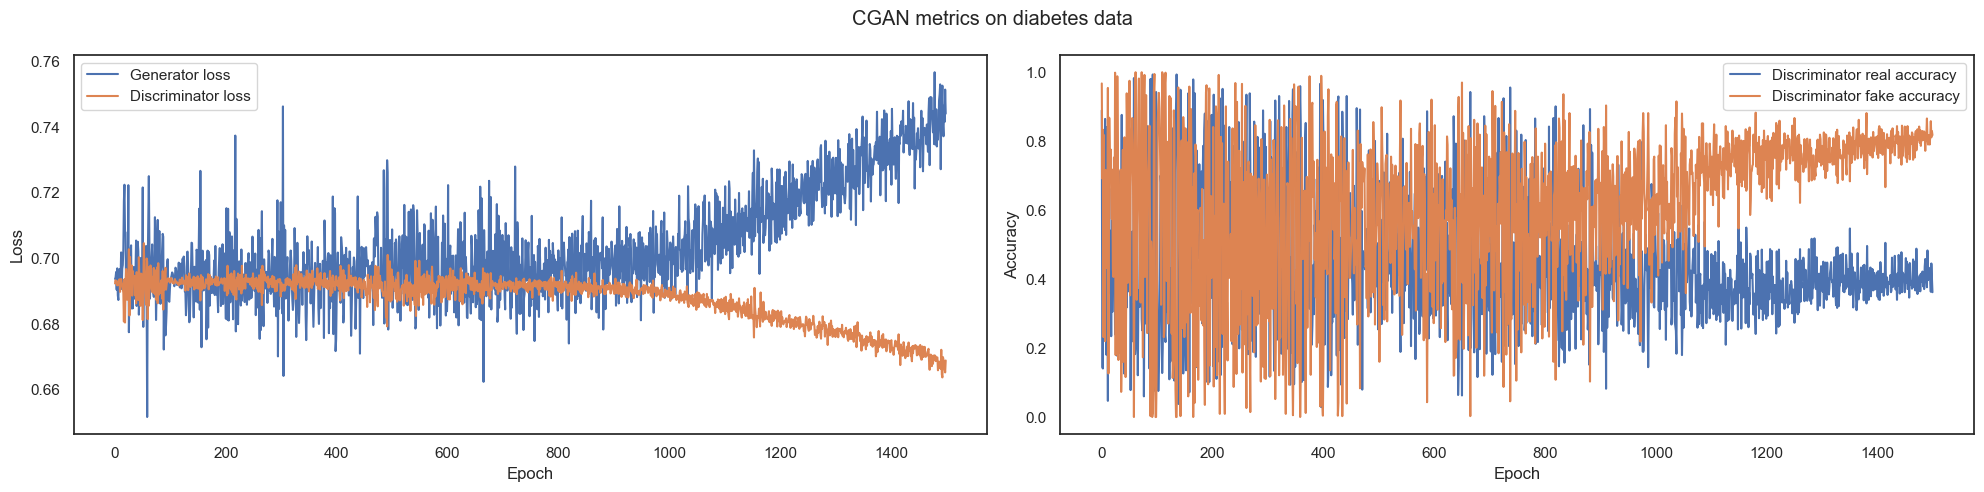

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on diabetes data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [ ]:
# Define number of samples to generate
num_samples = diabetes_X.shape[0]

# Get same labels as diabetes real labels
one_hot_labels = diabetes_y

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, one_hot_labels], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_diabetes_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_diabetes_df = pd.DataFrame(
    fake_records_and_labels, columns=clean_diabetes_df.columns
)

# Inverse preprocess
fake_diabetes_df = inverse_pre_process_data(
    fake_clean_diabetes_df, diabetes_num_cols, diabetes_cat_cols,
    diabetes_scalar, diabetes_encoder
)

# Sort fake data frame columns same as regular data frame columns 
fake_diabetes_df = fake_diabetes_df.reindex(diabetes_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

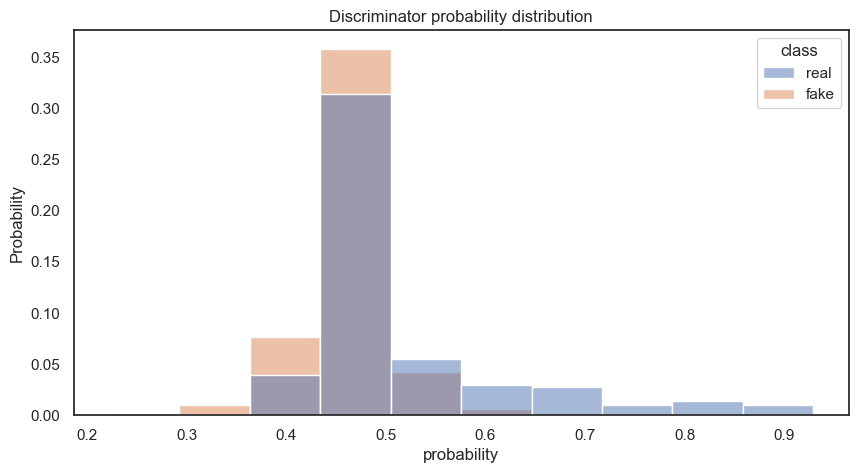

In [ ]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [ ]:
# Get records that fooled the discriminator
fooled = fake_diabetes_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 89


preg     plas    pres    skin     insu    mass   pedi     age  \
3   7.4737 147.4492 70.4209 26.1844 104.7815 26.6607 0.6242 65.4158   
6  11.5812 128.1913 76.9731 39.2189 235.6064 31.6616 0.7802 53.9625   
8   4.8471 148.5909 65.1356 30.2832 171.8436 28.8702 1.1992 24.7369   
9  14.9949 129.5001 82.6689 27.4262  57.4027 31.2568 0.2218 50.9599   
19  9.9887 152.0269 80.7614 24.9782  75.6045 26.6510 0.2458 50.3253   
23  0.0004 169.4560  0.0194  0.0000   0.0000 47.5794 0.3345 35.2289   
24  1.9767 153.3978  0.0285  0.0000   0.0000 33.7115 0.6046 25.0971   
31  0.0257 158.5532 87.9751 45.1267  88.8070 35.2092 1.5022 41.8356   
38  9.9156 177.4983 91.8948 31.6290  97.9621 35.3688 0.5738 43.9521   
51  6.6268 111.2876 66.8250 35.7260  49.1725 33.4442 0.7571 27.5204   

              class  
3   tested_negative  
6   tested_positive  
8   tested_positive  
9   tested_positive  
19  tested_positive  
23  tested_positive  
24  tested_positive  
31  tested_positive  
38  tested_positive  
51  tested_negative

In [ ]:
# Get records that did not fool the discriminator
not_fooled = fake_diabetes_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    f"Number of sample that did not fool the discriminator: {not_fooled.shape[0]}"
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 679


preg     plas    pres    skin     insu    mass   pedi     age  \
0   3.4976 124.6493 64.1158 33.8297 128.2580 29.4544 0.7453 25.0001   
1   0.6202 112.9488 66.0868 41.6414  48.6825 35.3579 0.7905 23.2634   
2   6.2085 186.1474 71.7695  0.6676  74.0015 34.7594 0.4491 38.6505   
4  13.2792 111.4773 57.8712 32.4383 566.1941 33.1955 0.4099 50.2603   
5   0.1709 116.7475 77.7863 22.6273 117.0368 27.1701 0.6677 25.6319   
7   9.5663  74.7566 72.6938  0.0000   0.0000 30.4638 0.2923 37.3267   
10  1.3682 128.0701 56.7817 39.0112 111.8448 36.2355 0.7030 21.8987   
11  0.2250 144.4756 66.1199 44.1045  85.2575 30.1464 0.9783 23.5851   
12  8.3888 109.1755 65.0737 33.1315  51.0425 31.9117 0.3685 41.9892   
13  4.2018 170.2437 71.2136 32.0639  61.6694 25.9124 0.3900 25.9135   

              class  
0   tested_positive  
1   tested_negative  
2   tested_positive  
4   tested_positive  
5   tested_negative  
7   tested_negative  
10  tested_negative  
11  tested_positive  
12  tested_negative  
13  tested_positive

Lets evaluate the generated samples using table evaluator:

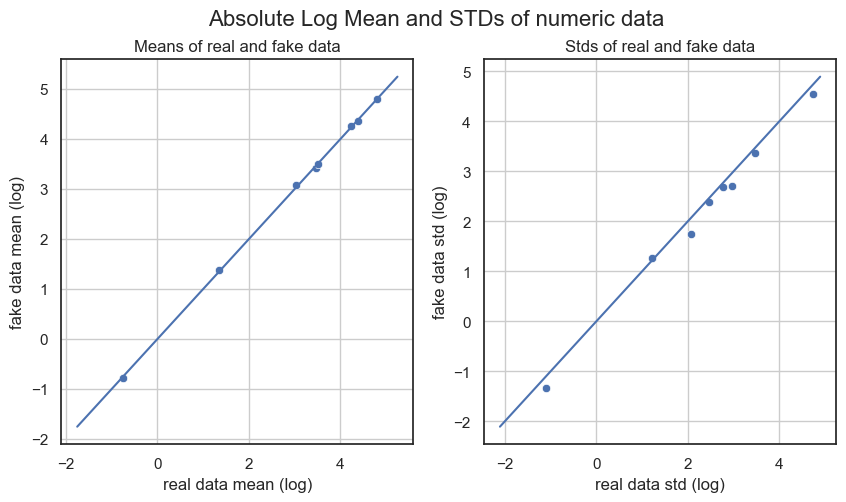

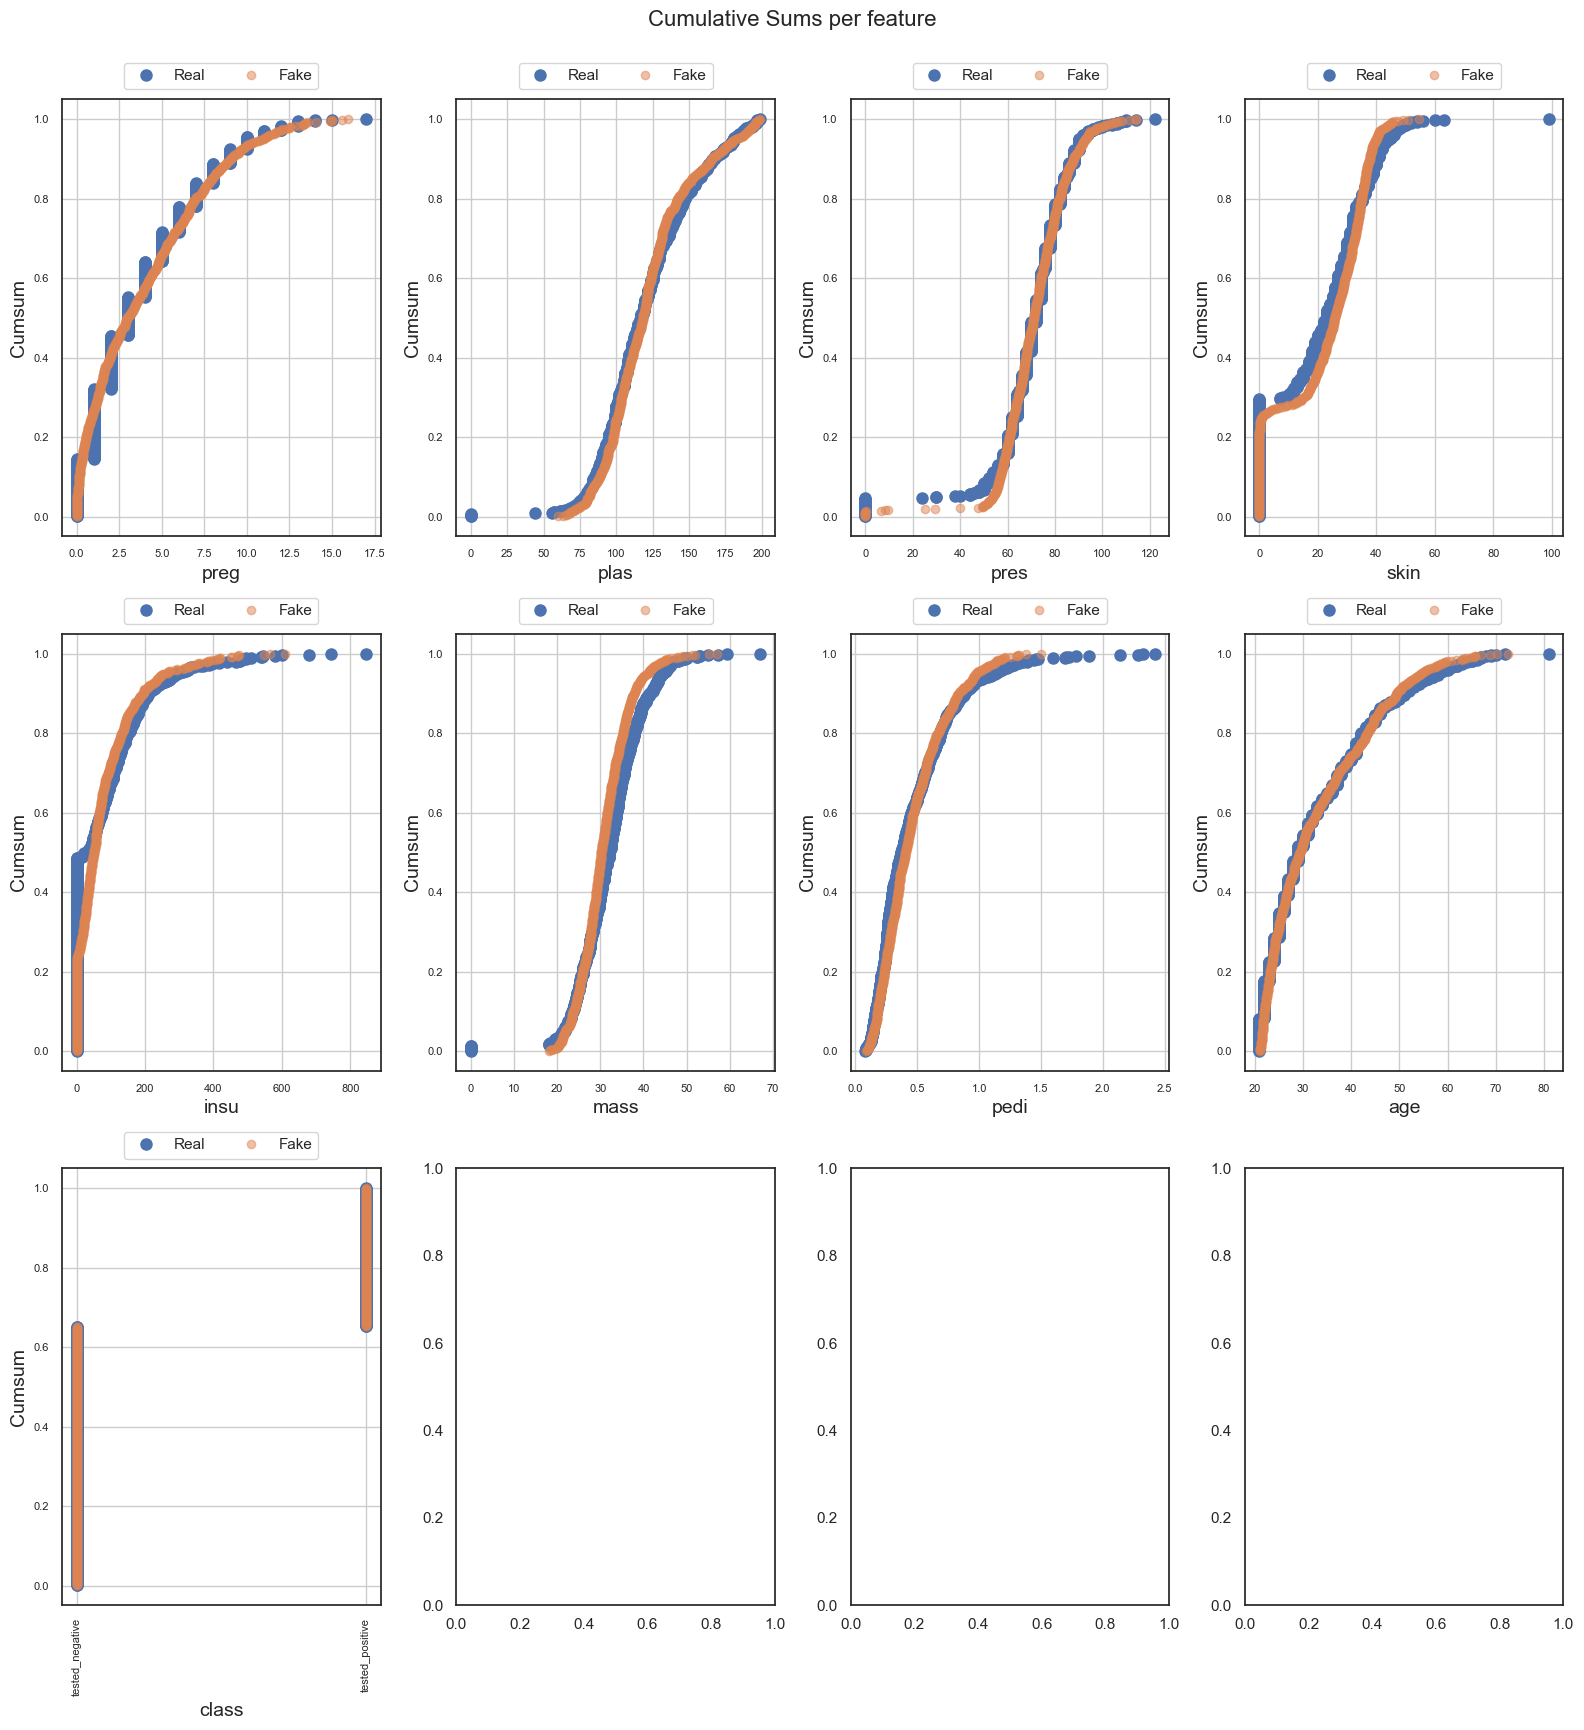

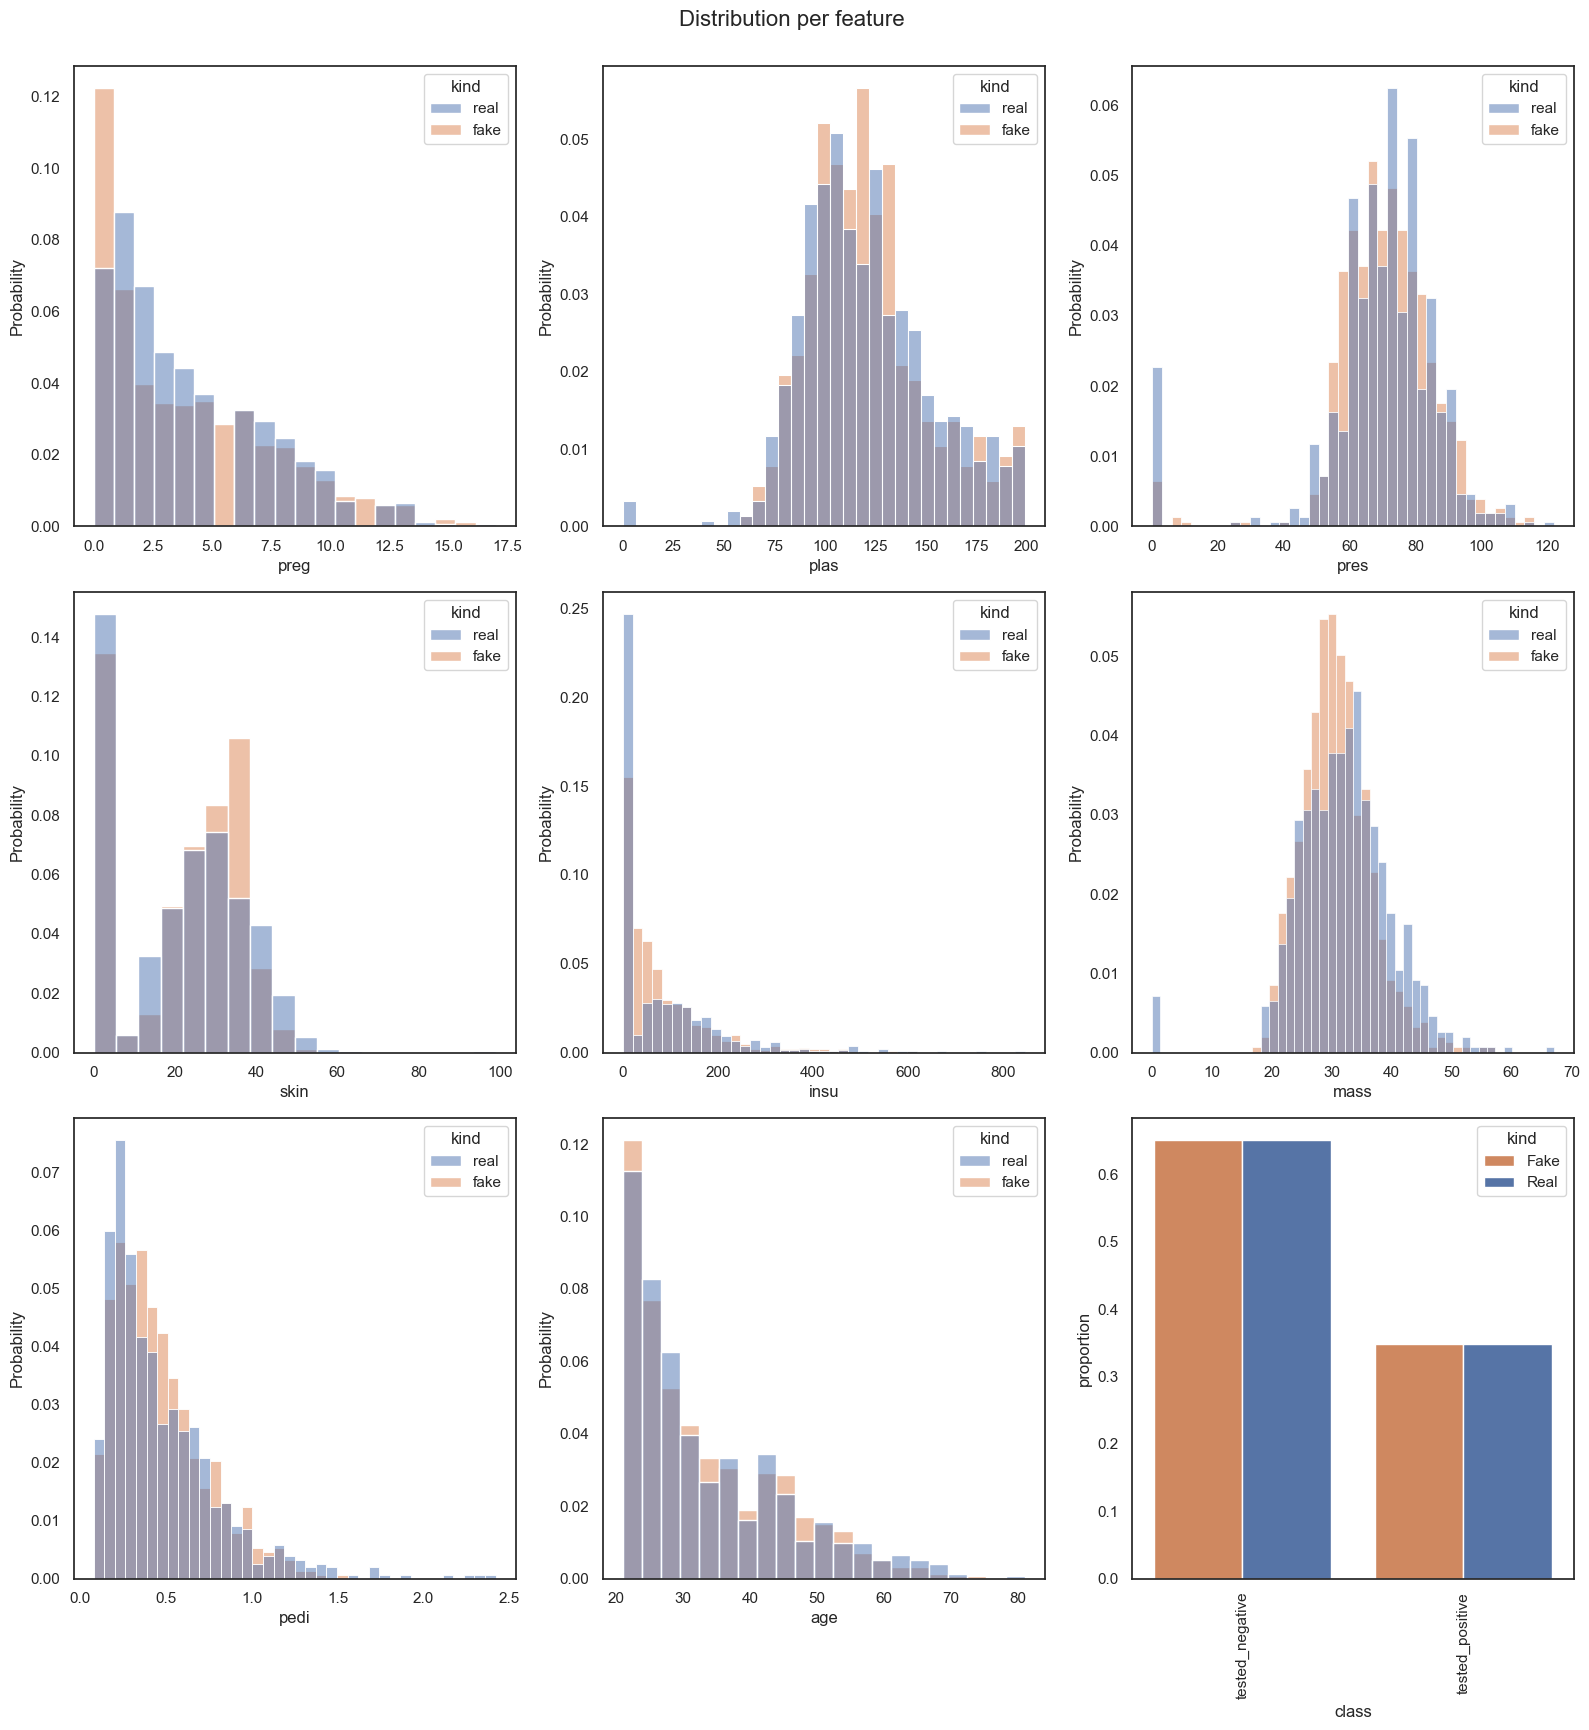

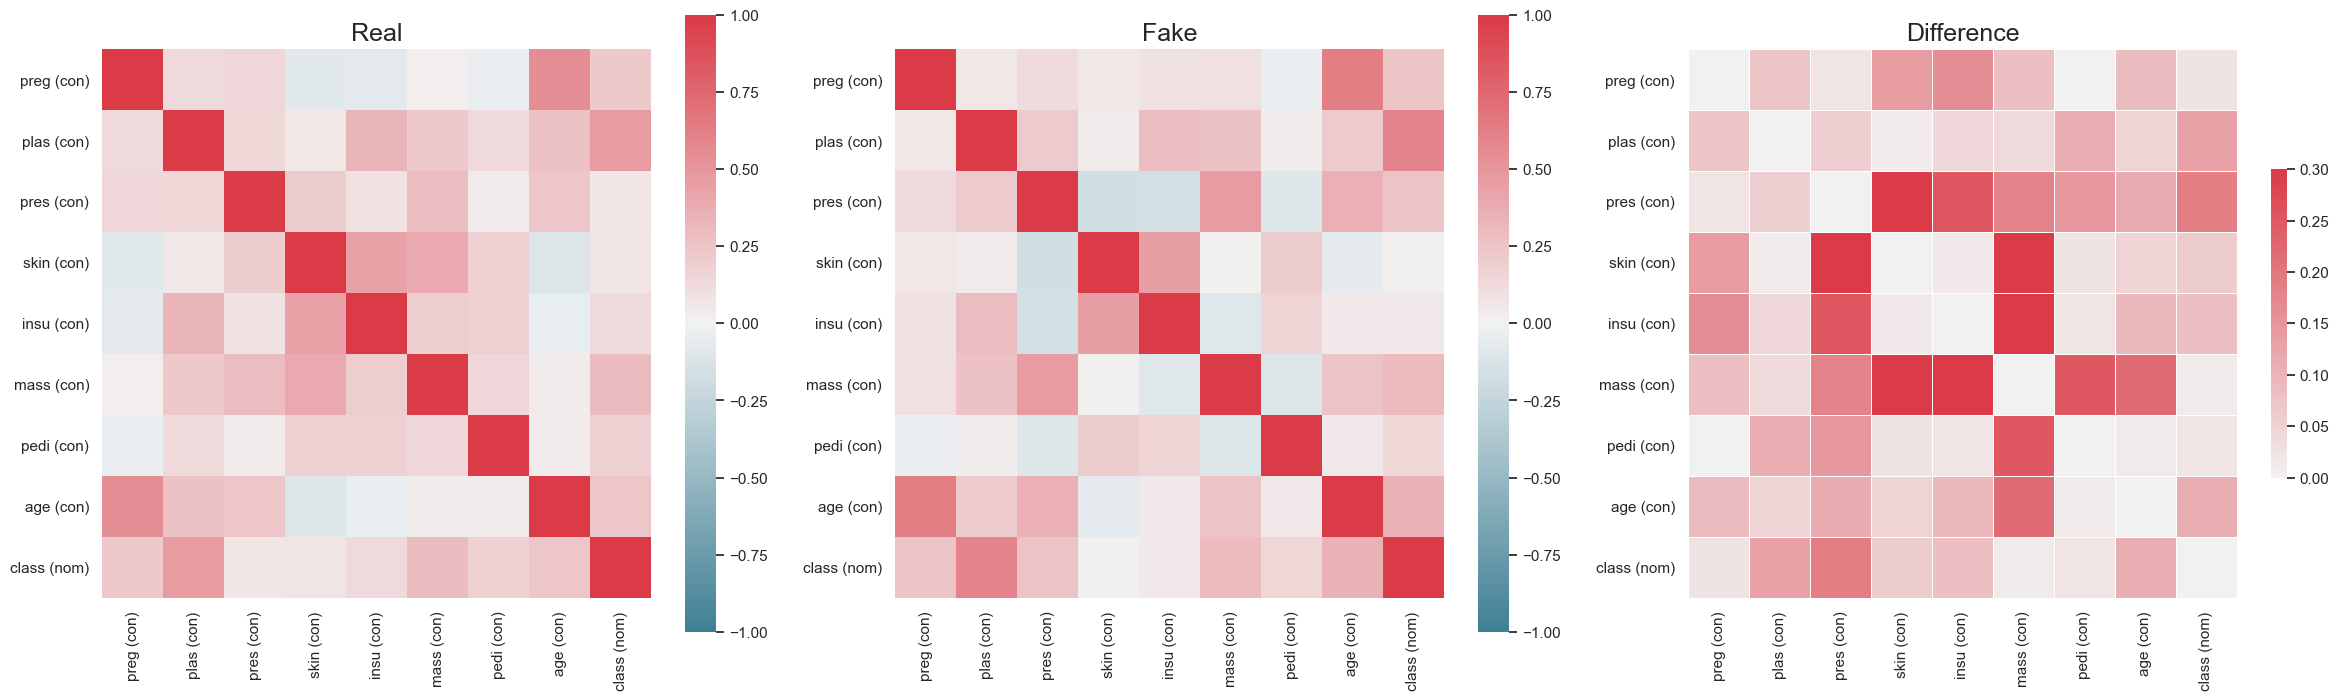

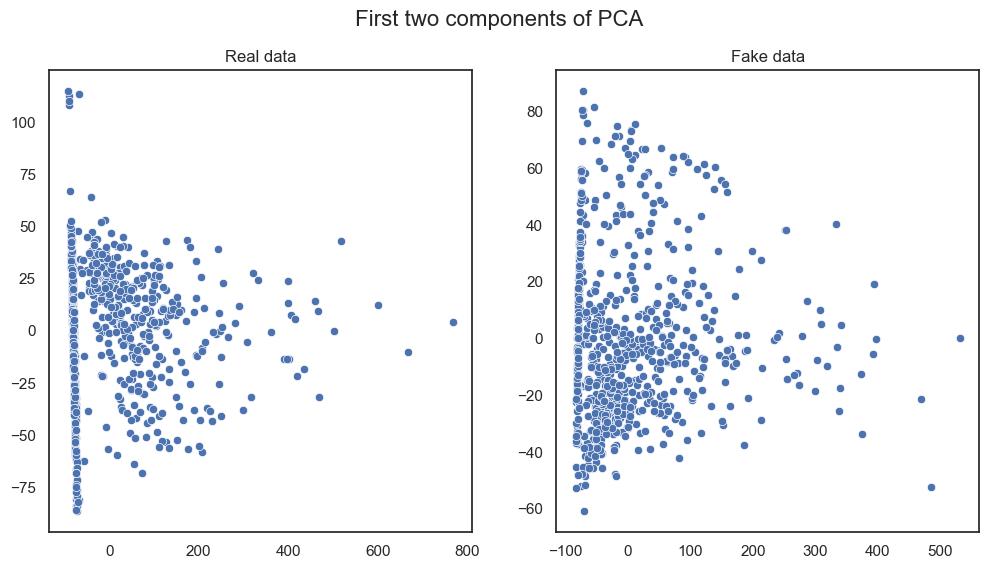


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7273   0.8506              0.5795
DecisionTreeClassifier_real   0.7468   0.7338              0.5876
LogisticRegression_fake       0.8247   0.8571              0.9130
LogisticRegression_real       0.7468   0.7468              0.8554
MLPClassifier_fake            0.6494   0.7727              0.4597
MLPClassifier_real            0.6883   0.6753              0.4951
RandomForestClassifier_fake   0.8571   0.8701              0.7303
RandomForestClassifier_real   0.7662   0.7532              0.6042

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.2024
nearest neighbor std                     0.5639

Miscellaneous results:
                                  Result
Column Cor

In [ ]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    diabetes_df, fake_diabetes_df, cat_cols=diabetes_cat_cols.to_list()
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="class")

##### ***German Credit training & evaluation***

Next, let's train a conditional GAN on the germen credit data:

In [ ]:
# Define dimension values
latent_dim = 128
g_layer_dim = 512
d_layer_dim = 128
data_dim = g_credit_X.shape[-1]
num_class = g_credit_y.shape[-1]

# Create CGAN
gen = make_generator(latent_dim + num_class, g_layer_dim, data_dim)
dis = make_discriminator(d_layer_dim, data_dim + num_class)
cgan = CGAN(gen, dis, latent_dim)

# Compile CGAN
cgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=MOMENTUM_RATE
    ), loss_fn=losses.BinaryCrossentropy(label_smoothing=0.3)
)

# Train CGAN
history = cgan.fit(
    g_credit_X, g_credit_y, epochs=200, shuffle=True,
    batch_size=BATCH_SIZE
)

Epoch 1/200
32/32 [==============================] - 2s 12ms/step - g_loss: 0.6927 - d_loss: 0.6921 - d_real_acc: 0.9258 - d_fake_acc: 0.7877
Epoch 2/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.7012 - d_loss: 0.6919 - d_real_acc: 0.1567 - d_fake_acc: 1.0000
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - g_loss: 0.6901 - d_loss: 0.6889 - d_real_acc: 0.9440 - d_fake_acc: 0.4912
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - g_loss: 0.7082 - d_loss: 0.6901 - d_real_acc: 0.1405 - d_fake_acc: 0.8955
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.6906 - d_loss: 0.6927 - d_real_acc: 0.7324 - d_fake_acc: 0.3860
Epoch 6/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.6984 - d_loss: 0.6907 - d_real_acc: 0.4770 - d_fake_acc: 0.8210
Epoch 7/200
32/32 [==============================] - 0s 7ms/step - g_loss: 0.7170 - d_loss: 0.6876 - d_real_acc: 0.1733 - d_fake_acc: 0.8892
Epoch 8/200


Next, let's plot training metrics:

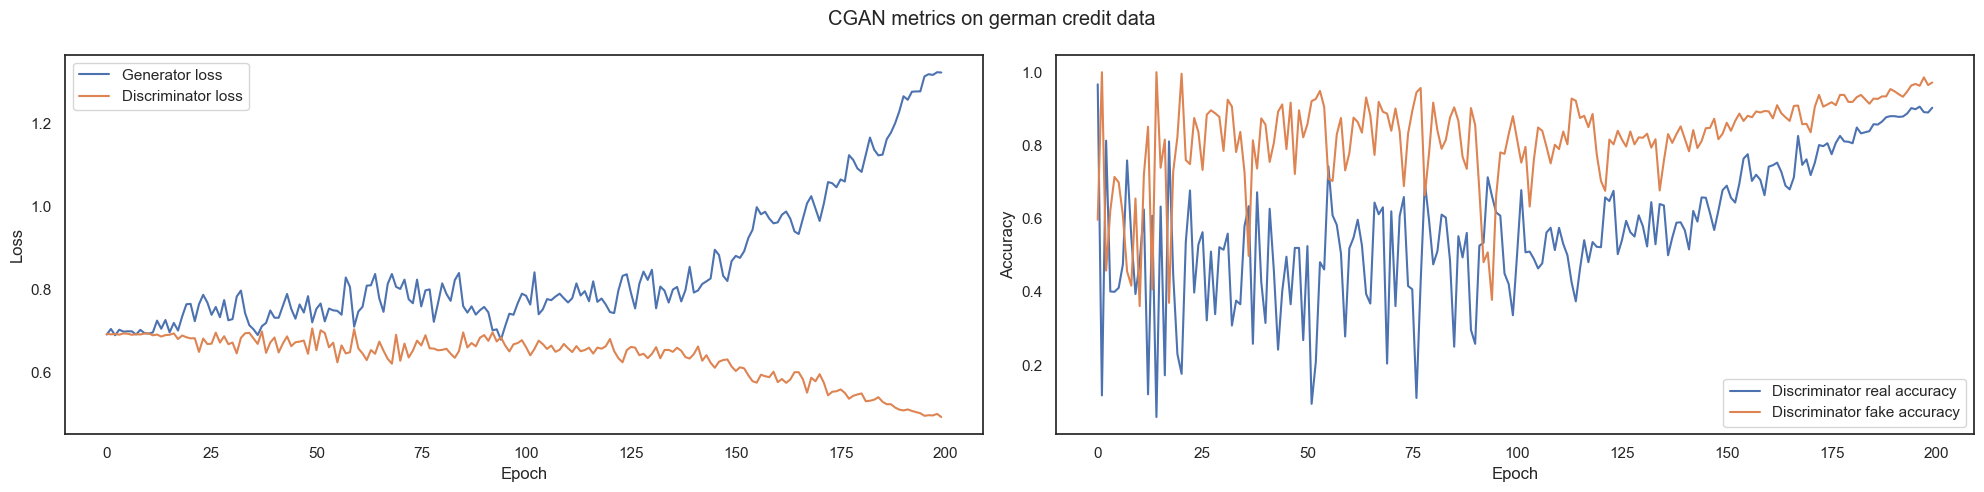

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot generator and discriminator loss
ax[0].plot(history.history["g_loss"], label="Generator loss")
ax[0].plot(history.history["d_loss"], label="Discriminator loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
# Plot real and fake accuracy
ax[1].plot(history.history["d_real_acc"], label="Discriminator real accuracy")
ax[1].plot(history.history["d_fake_acc"], label="Discriminator fake accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
# Set title
fig.suptitle("CGAN metrics on german credit data")
# Show plot
plt.tight_layout()
plt.show()

Next, let's generate some samples and get the discriminator prediction for them:

In [ ]:
# Define number of samples to generate
num_samples = g_credit_X.shape[0]

# Get same labels as diabetes real labels
one_hot_labels = g_credit_y

# Sample random points in the latent space for the generator
# and concatenate the labels.
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

# Generate fake records
fake_records = cgan.generator.predict(random_vector_labels)
fake_records_and_labels = tf.concat([fake_records, one_hot_labels], axis=1)

# Get discriminator predictions for fake and real dataset
d_fake_predictions = pd.DataFrame(
    cgan.discriminator.predict(fake_records_and_labels),
    columns=["probability"]
)
d_real_predictions = pd.DataFrame(
    cgan.discriminator.predict(clean_g_credit_df), columns=["probability"]
)

# Create a fake data frame
fake_clean_g_credit_df = pd.DataFrame(
    fake_records_and_labels, columns=clean_g_credit_df.columns
)

# Inverse preprocess
fake_g_credit_df = inverse_pre_process_data(
    fake_clean_g_credit_df, g_credit_num_cols, g_credit_cat_cols,
    g_credit_scalar, g_credit_encoder
)

# Sort fake data frame columns same as regular data frame columns 
fake_g_credit_df = fake_g_credit_df.reindex(g_credit_df.columns, axis=1)

Next, let's plot the probability to be real for the generated samples:

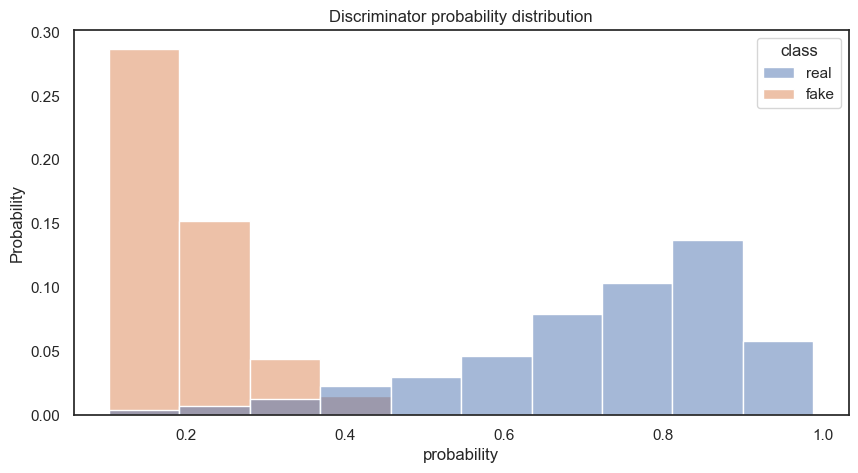

In [ ]:
# Add class to data frame for concat
d_real_predictions["class"] = "real"
d_fake_predictions["class"] = "fake"

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot probability
sns.histplot(
    pd.concat([d_real_predictions, d_fake_predictions], ignore_index=True),
    x="probability", hue="class", bins=10, stat="probability", ax=ax
)

# Show plot
plt.title("Discriminator probability distribution")
plt.show()

Next, let's get the samples that did and didn't manage fool the discriminator:

In [ ]:
# Get records that fooled the discriminator
fooled = fake_g_credit_df[d_fake_predictions["probability"] > 0.5]
# Print number of fooled records
print(f"Number of sample that did fool the discriminator: {fooled.shape[0]}")
# Show some of the fooled records
fooled.head(10)

Number of sample that did fool the discriminator: 1


1       2    3    4          5    6    7      8    9    10  ...    12  \
474  A11 16.4626  A34  A43 1,089.1325  A61  A75 3.9999  A93  A102  ...  A124   

         13    14    15     16    17     18    19    20 21  
474 43.5715  A143  A151 2.0218  A172 1.0000  A191  A201  2  

[1 rows x 21 columns]

In [ ]:
# Get records that did not fool the discriminator
not_fooled = fake_g_credit_df[d_fake_predictions["probability"] <= 0.5]
# Print number of not fooled records
print(
    f"Number of sample that did not fool the discriminator: {not_fooled.shape[0]}"
)
# Show some of the not fooled records
not_fooled.head(10)

Number of sample that did not fool the discriminator: 999


1       2    3    4          5    6    7      8    9    10  ...    12  \
0  A12 18.9309  A34  A43 1,370.4148  A61  A73 3.4900  A93  A101  ...  A123   
1  A11 23.3957  A34  A49 4,336.5348  A61  A73 3.7311  A93  A101  ...  A123   
2  A13 23.2366  A34  A49   897.6245  A61  A73 3.9774  A93  A101  ...  A123   
3  A12 29.6422  A33  A42 8,387.0774  A65  A73 1.0082  A92  A101  ...  A123   
4  A14 29.4792  A34  A42 7,206.9007  A61  A73 3.8862  A93  A101  ...  A122   
5  A11 16.8167  A32  A43 3,470.2462  A61  A73 3.8183  A93  A101  ...  A123   
6  A12 13.8834  A31  A49   877.6801  A61  A74 3.9645  A93  A101  ...  A123   
7  A14 40.1694  A34  A42 4,810.7716  A62  A72 3.9848  A92  A101  ...  A121   
8  A14 16.2548  A32  A41 5,103.8028  A65  A73 2.3354  A93  A101  ...  A123   
9  A12 35.7355  A34  A42 3,792.0200  A61  A73 1.8643  A93  A101  ...  A123   

       13    14    15     16    17     18    19    20 21  
0 28.9857  A141  A152 1.3895  A172 1.0008  A192  A201  1  
1 25.4621  A141  A152 1.9612  A173 1.0019  A192  A201  2  
2 38.8254  A141  A152 2.3867  A172 1.0003  A192  A201  1  
3 25.0783  A143  A152 1.2115  A174 1.0006  A192  A201  1  
4 37.9595  A143  A152 2.4092  A173 1.0001  A191  A201  2  
5 34.4055  A141  A152 2.2815  A173 1.0034  A192  A201  1  
6 20.4742  A141  A152 1.0903  A174 1.0001  A192  A201  1  
7 37.1083  A143  A152 1.4277  A172 1.0000  A191  A201  1  
8 27.1427  A141  A152 1.3340  A173 1.0003  A191  A201  1  
9 26.0091  A143  A152 1.6267  A172 1.0009  A191  A201  2  

[10 rows x 21 columns]

Lets evaluate the generated samples using table evaluator:

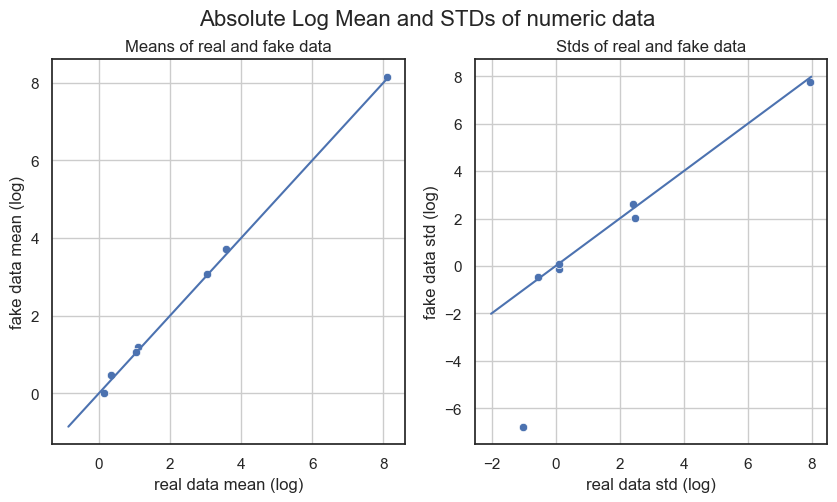

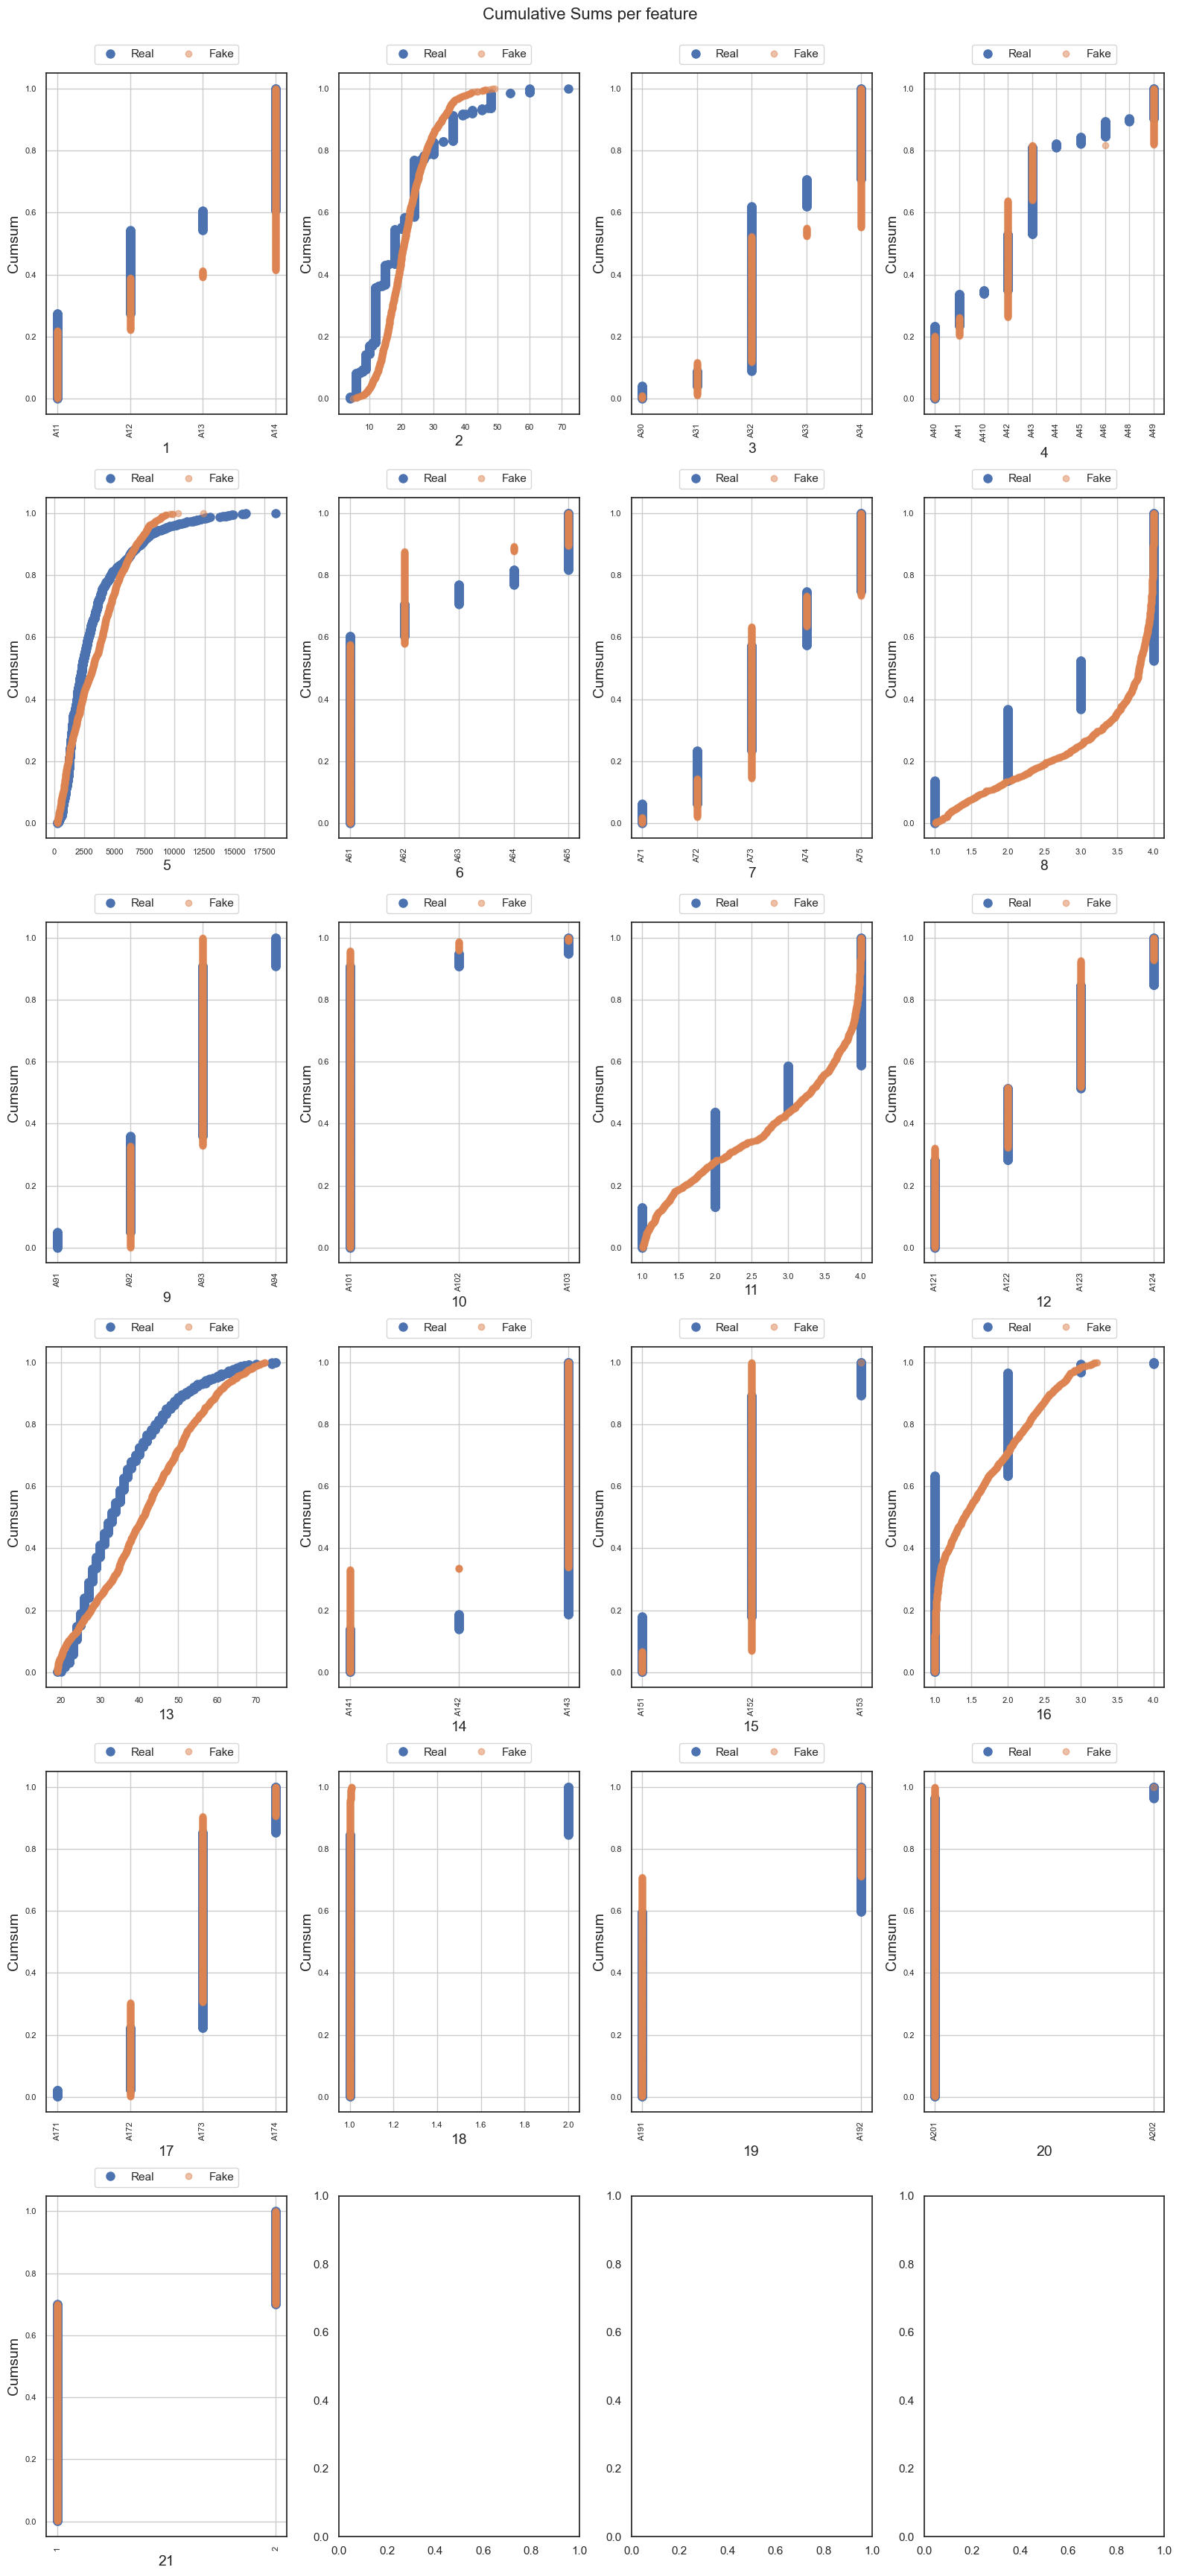

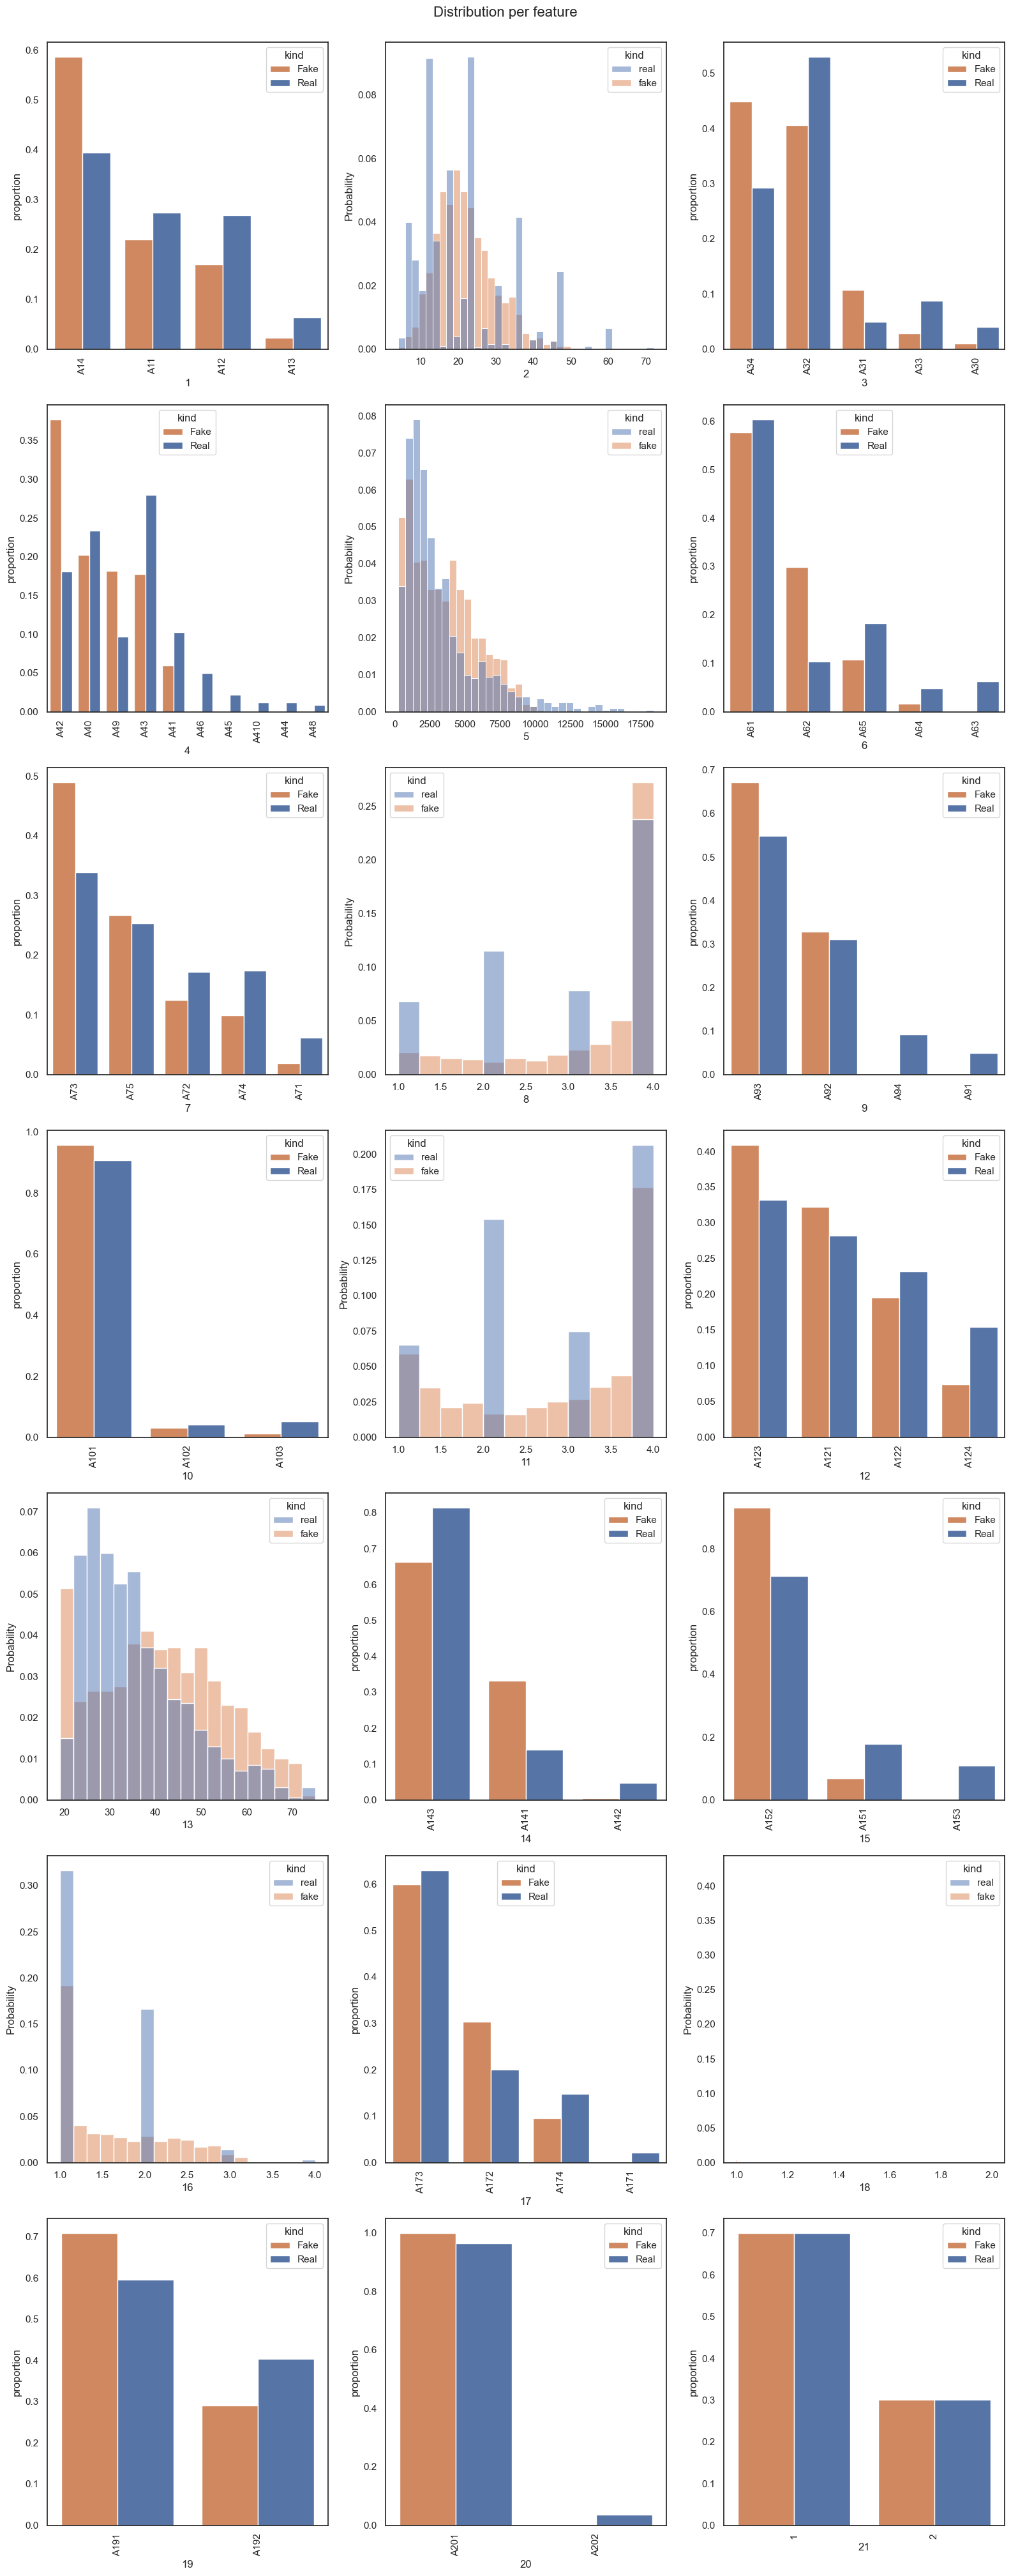

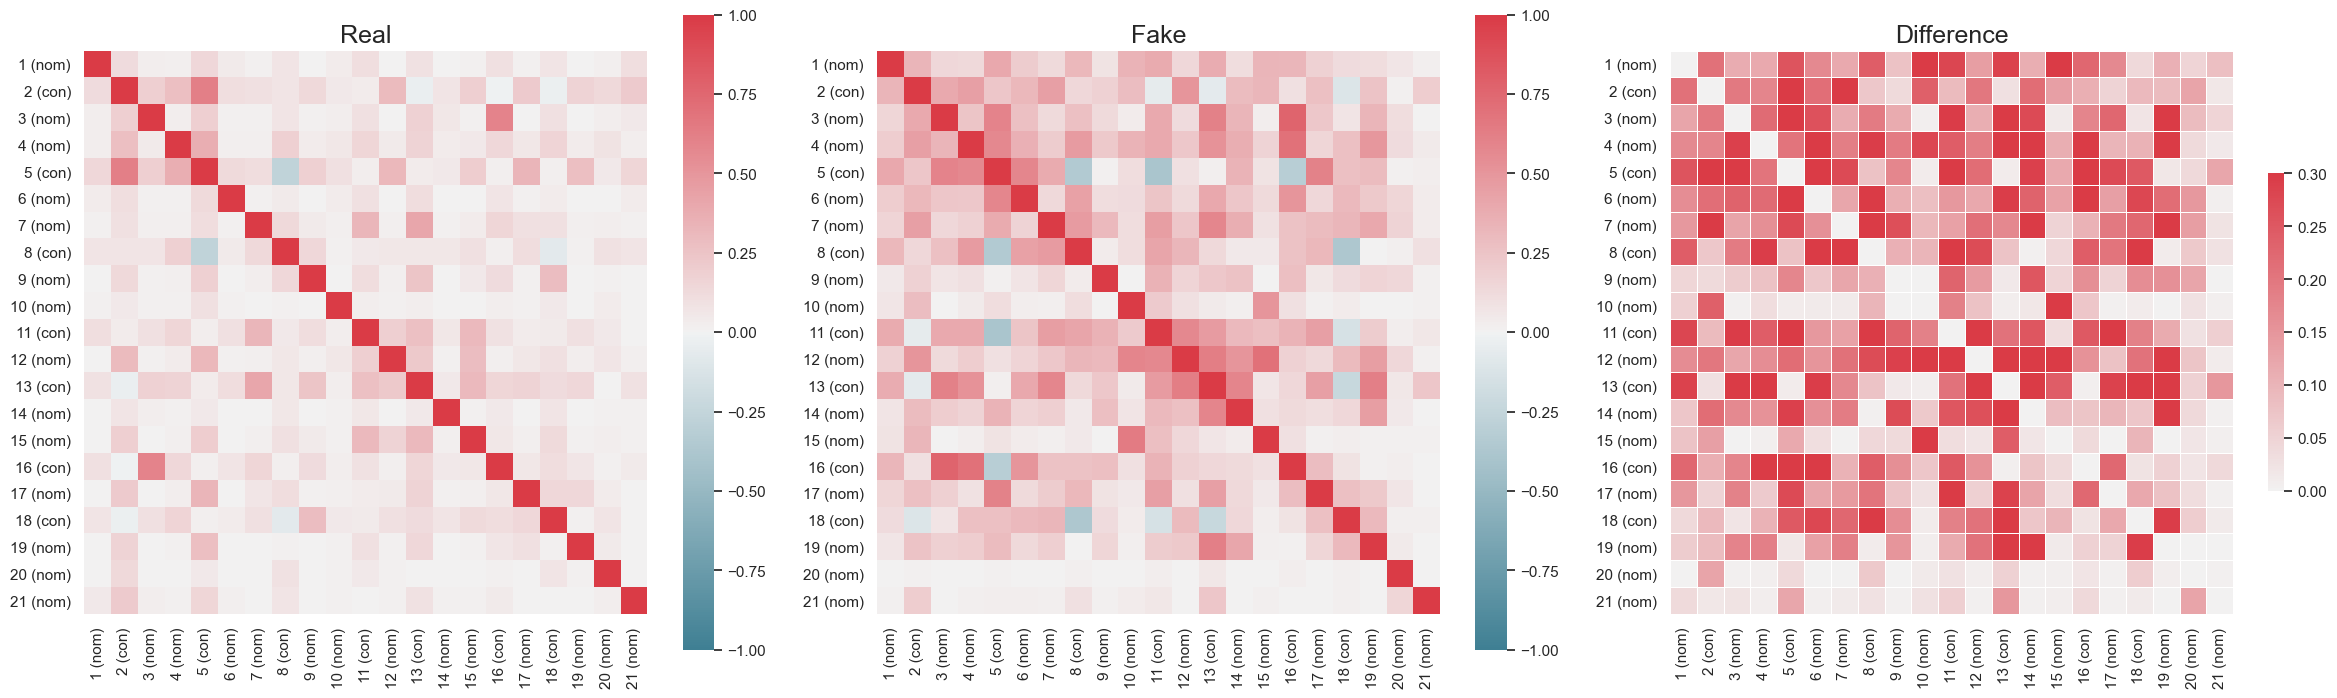

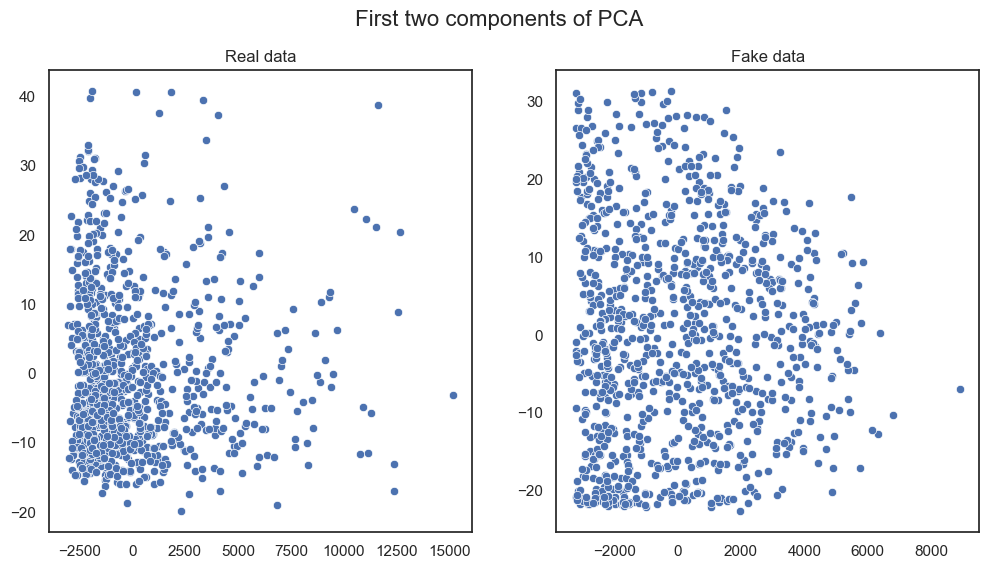


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.5650   0.7050              0.3889
DecisionTreeClassifier_real   0.6750   0.5550              0.3333
LogisticRegression_fake       0.6600   0.7450              0.6327
LogisticRegression_real       0.7750   0.7100              0.6327
MLPClassifier_fake            0.6950   0.6700              0.8779
MLPClassifier_real            0.7300   0.7200              0.8692
RandomForestClassifier_fake   0.6650   0.7500              0.6327
RandomForestClassifier_real   0.7300   0.6650              0.4981

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    3.3833
nearest neighbor std                     0.4345

Miscellaneous results:
                                  Result
Column Cor

In [ ]:
# Create table evaluator object
table_evaluator = TableEvaluator(
    g_credit_df, fake_g_credit_df, cat_cols=g_credit_cat_cols.to_list()
)
# Plots evaluation
table_evaluator.visual_evaluation()
#
table_evaluator.evaluate(target_col="21")